# Case Study: Personalized Cancer Diagnosis

## 1. Business problem:

### Description:

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 
- Data: Memorial Sloan Kettering Cancer Center (MSKCC)
- Download training_variants.zip and training_text.zip from Kaggle.

### problem statement:

- Classify the given genetic variations/mutations based on evidence from text-based clinical literature. 

### Real world/Business objectives and constraints:

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## Data:


### Data overview:

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID.
- Data file's information:

        training_variants (ID , Gene, Variations, Class)
        training_text (ID, Text)

### Example datapoint:
** training_variants: **

- ID,Gene,Variation,Class
- 0,FAM58A,Truncating Mutations,1 
- 1,CBL,W802*,2 
- 2,CBL,Q249E,2 
- .....

** training_text:**

- ID,Text 
- 0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

## 2. Mapping machine problem to ML problem:


### Type of machine learning problem:

- There are nine different classes a genetic mutation can be classified into => Multi class classification problem.

### Performance Metric:

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

### Machine Learing Objectives and Constraints:

- Objective: Predict the probability of each data-point belonging to each of the nine classes.
- Constraints:
              
           1. Interpretability
           2. Class probabilities are needed.
           3. Penalize the errors in class probabilites => Metric is Log-loss.
           4. No Latency constraints.

### Train, CV and Test datasets:

- Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively.

In [4]:
#To ignore warnings
import warnings 
warnings.filterwarnings("ignore")

In [5]:
# Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
   pickle.dump(obj,open(filename,"wb"))


def openfromfile(filename):
   temp = pickle.load(open(filename,"rb"))
   return temp

In [196]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import log_loss
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [7]:
#Reading the training_variaents which is an csv file consisting description of genetic mutations
df1 = pd.read_csv("training_variants")
print("Number of datapoints :", df1.shape[0])
print("Number of features :", df1.shape[1])
print("Feature names:", df1.columns.values)
df1.head()

Number of datapoints : 3321
Number of features : 4
Feature names: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


- training/training_variants is a comma separated file containing the description of the genetic mutations used for training.
- Fields are :

              ID  : the id of the row used to link the mutation to the clinical evidence.
            Gene  : the gene where this genetic mutation is located. 
       Variation  : the aminoacid change for this mutations.
            Class : 1-9 the class this genetic mutation has been classified on.

In [8]:
# Reading the training_file which is consisting of an clinical text data
df2 = pd.read_csv("training_text", sep='\|\|', names=['ID', 'TEXT'], skiprows=1, engine='python')
print("Number of datapoints:", df2.shape[0])
print("Number of features:", df2.shape[1])
print("Feature names are:", df2.columns.values)
df2.head()

Number of datapoints: 3321
Number of features: 2
Feature names are: ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
# Merging the two dataframes df1 and df2
dataframe = pd.merge(df1, df2, how='left', on='ID', )
print("Number of data points:", dataframe.shape[0])
print("Number of features:", dataframe.shape[1])
print("Feature names are:", dataframe.columns.values)
dataframe.head()

Number of data points: 3321
Number of features: 5
Feature names are: ['ID' 'Gene' 'Variation' 'Class' 'TEXT']


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [10]:
#Description about the data
dataframe.describe(include='all')

,ID,Gene,Variation,Class,TEXT
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


- Independent variables are ID, Gene, Variation and TEXT, Dependent variable is Class.
- ID feature is an numerical variable.
- Gene feature is an categorical variable.
- Variation feature is an categorical variable.
- TEXT feature is consisting of an text feature.

In [11]:
# In text feature some of the rows does not have data which means NaN, removing that entire rows from the dataframe
removing_rows = []
for row_no, sent in enumerate(dataframe.TEXT):
    if(pd.isnull(sent) == True):
        removing_rows.append(row_no)

new_dataframe = dataframe.drop(axis=0, index=removing_rows)
#Reseting the indices from new_dataframe
new_dataframe.reset_index(drop=True, inplace=True)

In [12]:
#Now shape of new_dataframe
print("Shape of new_dataframe:", new_dataframe.shape)
print("Number of datapoints:", new_dataframe.shape[0])
print("Number of features:", new_dataframe.shape[1])

Shape of new_dataframe: (3316, 5)
Number of datapoints: 3316
Number of features: 5


### Text Preprocessing for an TEXT feature:

#### 1. Removal of HTML Tags

#### 2. Removal of punctuations or Special characters

#### 3. Converting all text into the small letters

#### 4. Removing of stop words

#### 5. Stemmimg

In [12]:
#Storing all stopwords 
stop_words = set(stopwords.words('english'))

#stemming using porter stemming
sno = nltk.stem.SnowballStemmer('english')

#Function for removal of html tags, if present in the text
def cleanhtml(text):
    removed_html_text = re.sub('<.*?>', '', text)
    return removed_html_text

#Function for removal of punctuations from the text if present
def cleanpunc(text):
    text1 = re.sub(r'[?|!|\'|"|#]',r'',text)
    removed_punc = re.sub(r'[.|,|)|(|\|/]',r' ',text1)
    return removed_punc

In [13]:

#Function for Text pre-processing
def preprocess_data(data):
    #creating an empty list to store all preprocessed data
    preprocessed_data = []
    row = 0
    for sent in data:
            preprocessed_text = []
            #Removing html tags for each sentence 
            sent = cleanhtml(sent)
            for word in sent.split():
                #Removal of punctuations
                for c_word in cleanpunc(word).split():
                    #word should be non-numeric and length of each word should be >2 
                    if((c_word.isalpha()) & (len(c_word)>2)):
                        #Converting words to be in lower case and that should not be an stop words
                        if(c_word.lower() not in stop_words):
                            #Doing the stemming
                            final_word = (sno.stem(c_word.lower())).encode('utf8')
                            preprocessed_text.append(final_word)
                        else:
                            continue
                    else:
                        continue

            str = b' '.join(preprocessed_text).decode('utf8')
            preprocessed_data.append(str)
            print(row, end='\r')
            row += 1
    return preprocessed_data

Wall time: 0 ns


In [14]:

%%time

#Storing preprocessed_text 
new_dataframe['TEXT'] = preprocess_data(new_dataframe['TEXT'])

Wall time: 10min 7s


In [15]:
#Storing that preprocessed text for the further usage
savetofile(new_dataframe.TEXT, "cancer_preprocessed_text_assign")

In [13]:
new_dataframe.TEXT = openfromfile("cancer_preprocessed_text_assign")

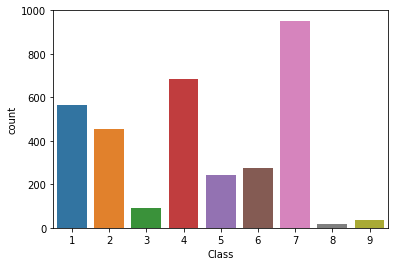

7    952
4    686
1    566
2    452
6    273
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [14]:
ax = plt.axes()
sns.countplot(new_dataframe.Class, ax=ax)
plt.show()
new_dataframe.Class.value_counts()

- observation: This dataset is an imbalanced, so majority class is 7.

In [15]:
#Unique Categories for categorical features
print("Number of categories in Gene Feature:", len(new_dataframe.Gene.value_counts()))
print("Number of categories in Variation Feature:", len(new_dataframe.Variation.value_counts()))

Number of categories in Gene Feature: 262
Number of categories in Variation Feature: 2993


In [16]:
new_dataframe.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,kinas cdks regul varieti fundament cellular pr...
1,1,CBL,W802*,2,abstract background cell lung cancer nsclc het...
2,2,CBL,Q249E,2,abstract background cell lung cancer nsclc het...
3,3,CBL,N454D,3,recent evid demonstr acquir uniparent disomi a...
4,4,CBL,L399V,4,oncogen mutat monomer casita lymphoma cbl gene...


In [17]:
#if category in categorical variable consisting of multiple words then making all into one word.
#replacing multiple spaces with underscore
new_dataframe.Gene = new_dataframe.Gene.str.replace('\s+', '_')
new_dataframe.Variation = new_dataframe.Variation.str.replace('\s+', '_')

### Splitting the dataset into train(64%),   test(20%),  cross validation(16%):

In [18]:
y = new_dataframe.Class
#Splitting data into train as 80% and test as 20%
#Keeping stratify because maintaing the class distribution same in train, test and cross validation
X_train, X_test, y_train, y_test = train_test_split(new_dataframe, y, stratify=y, test_size=0.2)

#Splitting train data into train as 64% and cv as 16%
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [19]:
print("Number of datapoints in train data:", X_tr.shape[0])
print("Number of datapoints in cv data:", X_cv.shape[0])
print("Number of datapoints in test data:", X_test.shape[0])

Number of datapoints in train data: 2121
Number of datapoints in cv data: 531
Number of datapoints in test data: 664


** Distribution of yi's in train, cv and test datasets:**

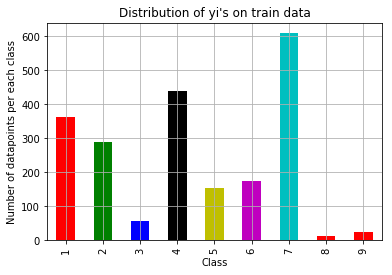

Number of datapoints in class 7 : 609 ( 0.287 %)
Number of datapoints in class 4 : 439 ( 0.207 %)
Number of datapoints in class 1 : 362 ( 0.171 %)
Number of datapoints in class 2 : 289 ( 0.136 %)
Number of datapoints in class 6 : 174 ( 0.082 %)
Number of datapoints in class 5 : 155 ( 0.073 %)
Number of datapoints in class 3 : 57 ( 0.027 %)
Number of datapoints in class 9 : 24 ( 0.011 %)
Number of datapoints in class 8 : 12 ( 0.006 %)


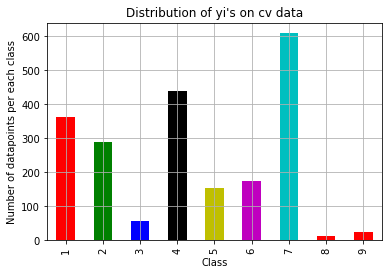

Number of datapoints in class 7 : 152 ( 0.286 %)
Number of datapoints in class 4 : 110 ( 0.207 %)
Number of datapoints in class 1 : 91 ( 0.171 %)
Number of datapoints in class 2 : 72 ( 0.136 %)
Number of datapoints in class 6 : 44 ( 0.083 %)
Number of datapoints in class 5 : 39 ( 0.073 %)
Number of datapoints in class 3 : 14 ( 0.026 %)
Number of datapoints in class 9 : 6 ( 0.011 %)
Number of datapoints in class 8 : 3 ( 0.006 %)


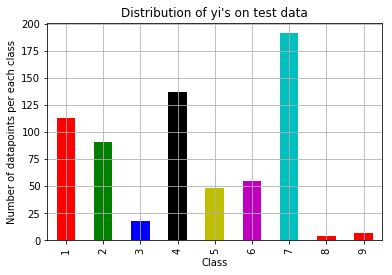

Number of datapoints in class 7 : 191 ( 0.288 %)
Number of datapoints in class 4 : 137 ( 0.206 %)
Number of datapoints in class 1 : 113 ( 0.17 %)
Number of datapoints in class 2 : 91 ( 0.137 %)
Number of datapoints in class 6 : 55 ( 0.083 %)
Number of datapoints in class 5 : 48 ( 0.072 %)
Number of datapoints in class 3 : 18 ( 0.027 %)
Number of datapoints in class 9 : 7 ( 0.011 %)
Number of datapoints in class 8 : 4 ( 0.006 %)


In [20]:
#It returns a dict, keys as class labels and value is an number of datapoints in that particular class

#Distribution for train data
train_data_distribution = X_tr.Class.value_counts().sortlevel()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_data_distribution.plot(kind='bar', color=my_colors)
plt.grid()
plt.title("Distribution of yi's on train data")
plt.xlabel("Class")
plt.ylabel("Number of datapoints per each class")
plt.show()

#Storing the indices are in decending order of distribution values
sorted_y = np.argsort(-train_data_distribution)
for i in sorted_y:
    print("Number of datapoints in class", i+1 , ":", train_data_distribution.values[i], "(", np.round(train_data_distribution.values[i] / sum(train_data_distribution.values), 3), "%)")

#Distribution for cv data
cv_data_distribution = X_cv.Class.value_counts().sortlevel()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_data_distribution.plot(kind='bar', color=my_colors)
plt.grid()
plt.title("Distribution of yi's on cv data")
plt.xlabel("Class")
plt.ylabel("Number of datapoints per each class")
plt.show()

#Storing the indices are in decending order of distribution values
sorted_y = np.argsort(-cv_data_distribution)
for i in sorted_y:
    print("Number of datapoints in class", i+1 , ":", cv_data_distribution.values[i], "(", np.round(cv_data_distribution.values[i] / sum(cv_data_distribution.values), 3), "%)")


#Distribution for test data
test_data_distribution = X_test.Class.value_counts().sortlevel()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_data_distribution.plot(kind='bar', color=my_colors)
plt.grid()
plt.title("Distribution of yi's on test data")
plt.xlabel("Class")
plt.ylabel("Number of datapoints per each class")
plt.show()

#Storing the indices are in decending order of distribution values
sorted_y = np.argsort(-test_data_distribution)
for i in sorted_y:
    print("Number of datapoints in class", i+1 , ":", test_data_distribution.values[i], "(", np.round(test_data_distribution.values[i] / sum(test_data_distribution.values), 3), "%)")

- Distribution of yi's on train, cv and test datasets are same.

## Generating the Random Model :

- From random model calculate log loss then we compare to all other models should be less than random model, log loss as less as possible for an good model log loss should be 0.

In [21]:
#Function for to plot confusion matrix, precision, recall matrices
def plot_confusion_matrix(y_true, y_pred):
    #finding the confusion matrix
    C = confusion_matrix(y_true, y_pred)
    #Creating the Recall matrix
    A =(((C.T)/(C.sum(axis=1))).T)
    #Creating the Precision matrix
    B =(((C.T)/(C.sum(axis=0))).T)
    
    labels = [1,2,3,4,5,6,7,8,9]
    

    print("-"*30, "Confusion matrix", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*30, "Precision matrix (Columm Sum=1)", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*30, "Recall matrix (Row sum=1)", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on cross validation data using an Random model: 2.524
Log loss on test data using an Random model: 2.506
------------------------------ Confusion matrix ------------------------------


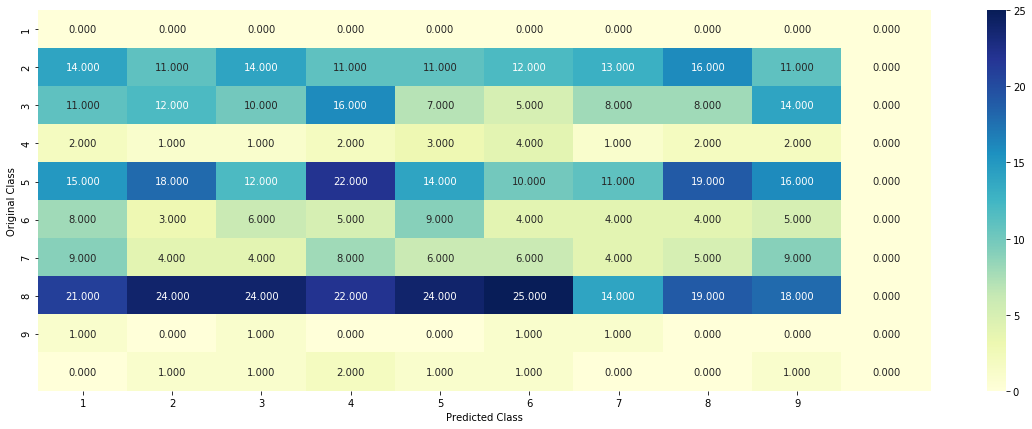

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


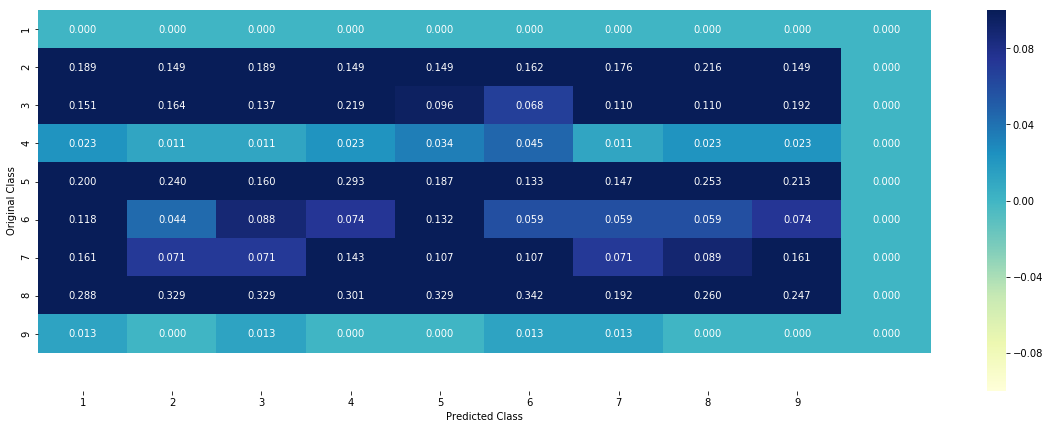

------------------------------ Recall matrix (Row sum=1) ------------------------------


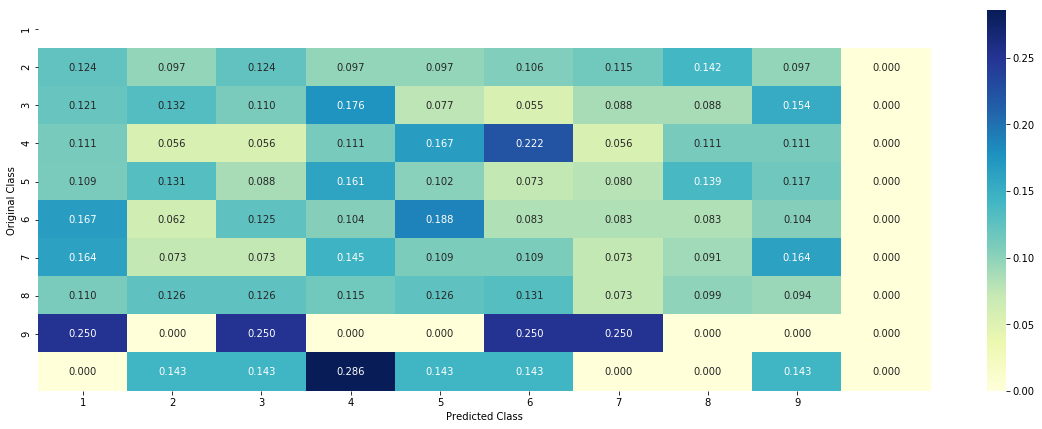

In [22]:
#Finding the length of test data
test_data_len = X_test.shape[0]
#Finding the length of cross validation data
cv_data_len = X_cv.shape[0]


#Finding the Log_loss on cross validation data using an Random model
#Creating an array of length of cv_data * number of classes
cv_predicted_yi = np.zeros((cv_data_len, 9))

#np.random.rand means generates uniform distribution numbers and np.random.randn means generating gaussian distribution
for i in range(cv_data_len):
    rand_nums = np.random.rand(1,9) # generating random numbers of 1 dim vector with 9 cells
    cv_predicted_yi[i] = ((rand_nums/sum(sum(rand_nums)))[0])
print("Log loss on cross validation data using an Random model:", np.round(log_loss(y_cv, cv_predicted_yi), 3))


#Finding the Log_loss on test data using Random model
test_predicted_yi = np.zeros((test_data_len, 9))

for i in range(test_data_len):
    rand_nums = np.random.rand(1,9)
    test_predicted_yi[i] = ((rand_nums/sum(sum(rand_nums)))[0])
print("Log loss on test data using an Random model:", np.round(log_loss(y_test, test_predicted_yi), 3))

#Finding the maximum index which has an high probability
predicted_yi = np.argmax(test_predicted_yi, axis=1)
#plotting the confusion matrix, precision and Recall matrices
plot_confusion_matrix(y_test, predicted_yi)

## Univariate Analysis:
## 1. Gene:

** 1. What type of gene feature is?**

- It is an Categorical feature

** 2. How many categories are there and how they are distributed? **

In [23]:
unique_gene = X_tr.Gene.value_counts()
print("number of categories for gene feature is:", unique_gene.shape[0])
unique_gene.head()

number of categories for gene feature is: 235


BRCA1    170
TP53      99
EGFR      96
PTEN      84
BRCA2     79
Name: Gene, dtype: int64

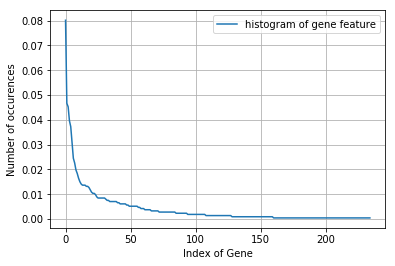

In [24]:
#Distribution as follows using histogram
s = sum(unique_gene.values)
his = unique_gene.values / s
plt.plot(his,label="histogram of gene feature")
plt.xlabel("Index of Gene")
plt.ylabel("Number of occurences")
plt.grid()
plt.legend()
plt.show()

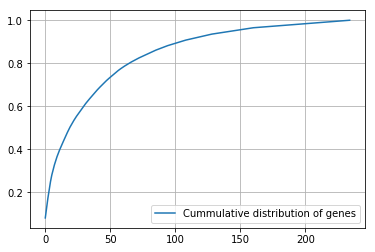

In [25]:
#cdf for gene feature
cdf = np.cumsum(his)
plt.plot(cdf, label="Cummulative distribution of genes")
plt.grid()
plt.legend()
plt.show()

** 3. How to featurize this feature?**

- Using onehotencoding 

** TFIDF: **
- TF-IDF stands for "Term Frequency, Inverse Document Frequency." It's a way to score the importance of words (or "terms") in a document based on how frequently they appear across multiple documents.

In [26]:
#onehot encoding for gene feature
count_vect = TfidfVectorizer(binary=True)
train_gene_onehotcoding = count_vect.fit_transform(X_tr.Gene)
cv_gene_onehotcoding = count_vect.transform(X_cv.Gene)
test_gene_onehotcoding = count_vect.transform(X_test.Gene)

In [27]:
print("train_gene_onehotcoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_onehotcoding.shape)

train_gene_onehotcoding is converted feature using one-hot encoding method. The shape of gene feature: (2121, 234)


** 4. How good gene feature in predicting y_i? **

- There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.4352133276606596
For values of alpha =  0.0001 The log loss is: 1.2494506497819895
For values of alpha =  0.001 The log loss is: 1.2546241855275257
For values of alpha =  0.01 The log loss is: 1.356393016383372
For values of alpha =  0.1 The log loss is: 1.4382444500311276
For values of alpha =  1 The log loss is: 1.4718018931723773


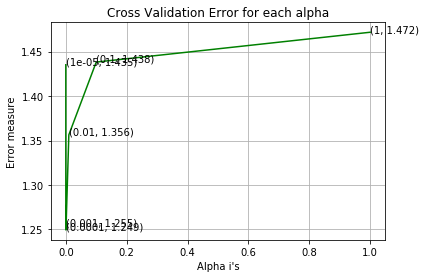

For values of best alpha =  0.0001 The train log loss is: 1.0387248520797607
For values of best alpha =  0.0001 The cv log loss is: 1.2494506497819895
For values of best alpha =  0.0001 The test log loss is: 1.2062225638057134


In [28]:
#Creating some alpha values are [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
alpha = [10 ** x for x in range(-5,1)]

#Finding the best hyperparameter using the cross validation
cv_log_errors = []
for x in alpha:
    clf = SGDClassifier(alpha=x, loss='log', random_state=42)
    clf.fit(train_gene_onehotcoding, y_tr)
    sig_clf = CalibratedClassifierCV(clf,  method='sigmoid')
    sig_clf.fit(train_gene_onehotcoding, y_tr)
    predict_y = sig_clf.predict_proba(cv_gene_onehotcoding)
    cv_log_errors.append(log_loss(y_cv, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', x, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_errors,c='g')
for i, txt in enumerate(np.round(cv_log_errors,3)):
     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_errors[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#Finding the training error, cv error and test error using the best hyperparameter
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(alpha=alpha[best_alpha], loss='log', random_state=42)
clf.fit(train_gene_onehotcoding, y_tr)
sig_clf = CalibratedClassifierCV(clf,  method='sigmoid')
sig_clf.fit(train_gene_onehotcoding, y_tr)

#Training error
predict_y = sig_clf.predict_proba(train_gene_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))

#cross validation error
predict_y = sig_clf.predict_proba(cv_gene_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cv log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

#Test error
predict_y = sig_clf.predict_proba(test_gene_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

** 5. Is gene feature stable across all the datasets(Train, cv and Test)? **

In [29]:
print("How many data points in Test and CV datasets are covered by the ", X_tr.Gene.value_counts().shape[0], " genes in train dataset?")
test_coverage = X_test[X_test.Gene.isin(list(set(X_tr.Gene)))].shape[0]
cv_coverage = X_cv[X_cv.Gene.isin(list(set(X_cv.Gene)))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

How many data points in Test and CV datasets are covered by the  235  genes in train dataset?
Ans
1. In test data 644 out of 664 : 96.98795180722891
2. In cross validation data 531 out of  531 : 100.0


## Variation feature:

** 1. what type of variation feature is? **

- It is an categorical feature

** 2. How many categories are there and how it is distributed?**

In [30]:
unique_var = X_tr.Variation.value_counts()
print("Number of categories in variation feature is:", unique_var.shape[0])
unique_var.head()

Number of categories in variation feature is: 1924


Truncating_Mutations    61
Deletion                46
Amplification           44
Fusions                 19
Overexpression           5
Name: Variation, dtype: int64

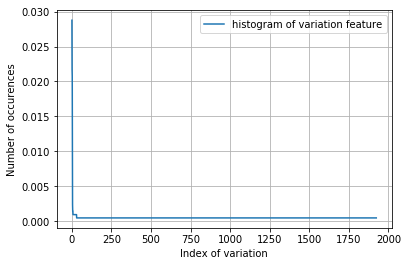

In [31]:
#Distribution as follows using histogram
s = sum(unique_var.values)
his = unique_var.values / s
plt.plot(his,label="histogram of variation feature")
plt.xlabel("Index of variation")
plt.ylabel("Number of occurences")
plt.grid()
plt.legend()
plt.show()

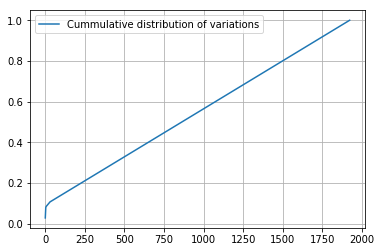

In [32]:
#cdf for gene feature
cdf = np.cumsum(his)
plt.plot(cdf, label="Cummulative distribution of variations")
plt.grid()
plt.legend()
plt.show()

** 3. How to featurize this feature? **

- Using an onehotencoding

In [33]:
#onehotencoding for variation feature
count_vec_var = TfidfVectorizer(binary=True)
train_var_onehotcoding = count_vec_var.fit_transform(X_tr.Variation)
cv_var_onehotcoding = count_vec_var.transform(X_cv.Variation)
test_var_onehotcoding = count_vec_var.transform(X_test.Variation)

In [34]:
print("train_variation_onehotcoding is converted feature using one-hot encoding method. The shape of variation feature:", train_var_onehotcoding.shape)

train_variation_onehotcoding is converted feature using one-hot encoding method. The shape of variation feature: (2121, 1955)


** 4. How good Variation feature predicing the y_i's?**

For values of alpha =  1e-05 The log loss is: 1.7003089483508131
For values of alpha =  0.0001 The log loss is: 1.685751263357274
For values of alpha =  0.001 The log loss is: 1.6862774287011353
For values of alpha =  0.01 The log loss is: 1.6943516040158682
For values of alpha =  0.1 The log loss is: 1.7026108557843231
For values of alpha =  1 The log loss is: 1.7035845135492993


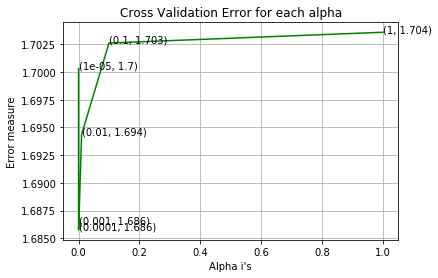

For values of best alpha =  0.0001 The train log loss is: 0.7701080064544252
For values of best alpha =  0.0001 The cv log loss is: 1.685751263357274
For values of best alpha =  0.0001 The test log loss is: 1.7418008100402878


In [35]:
#Creating list of hyperparameters are [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
alpha = [10 ** i for i in range(-5, 1)]

cv_log_errors = []
for x in alpha:
    clf = SGDClassifier(alpha=x, loss='log', penalty='l2', random_state=42)
    clf.fit(train_var_onehotcoding, y_tr)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_var_onehotcoding, y_tr)
    predict_y = sig_clf.predict_proba(cv_var_onehotcoding)
    cv_log_errors.append(log_loss(y_cv, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', x, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_errors,c='g')
for i, txt in enumerate(np.round(cv_log_errors,3)):
     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_errors[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#Finding the training error, cv error and test error using the best hyperparameter
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(alpha=alpha[best_alpha], loss='log', random_state=42)
clf.fit(train_var_onehotcoding, y_tr)
sig_clf = CalibratedClassifierCV(clf,  method='sigmoid')
sig_clf.fit(train_var_onehotcoding, y_tr)

#Training error
predict_y = sig_clf.predict_proba(train_var_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))

#cross validation error
predict_y = sig_clf.predict_proba(cv_var_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cv log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

#Test error
predict_y = sig_clf.predict_proba(test_var_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

** 5. Is the variation feature stable across all the data sets (Test, Train, Cross validation)? **

In [36]:
print("How many data points in Test and CV datasets are covered by the ", X_tr.Variation.value_counts().shape[0], " variations in train dataset?")
test_coverage = X_test[X_test.Variation.isin(list(set(X_tr.Variation)))].shape[0]
cv_coverage = X_cv[X_cv.Variation.isin(list(set(X_tr.Variation)))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

How many data points in Test and CV datasets are covered by the  1924  variations in train dataset?
Ans
1. In test data 62 out of 664 : 9.33734939759036
2. In cross validation data 59 out of  531 : 11.11111111111111


## 3. TEXT feature:

In [151]:
#onehotencoding for text feature
#Taking the top most 1000 important features 
count_vec_text = TfidfVectorizer(min_df=3, max_features=1000)
train_text_onehotcoding = count_vec_text.fit_transform(X_tr.TEXT)
#normalizing the train data and axis=0 means normalize based on the features
train_text_onehotcoding = normalize(train_text_onehotcoding, axis=0)

# we can use the same vectorizer that can be used in train data
cv_text_onehotcoding = count_vec_text.transform(X_cv.TEXT)
#normalizing the cv data
cv_text_onehotcoding = normalize(cv_text_onehotcoding, axis=0)

test_text_onehotcoding = count_vec_text.transform(X_test.TEXT)
test_text_onehotcoding = normalize(test_text_onehotcoding, axis=0)

In [38]:
print("train_text_onehotcoding is converted feature using one-hot encoding method. The shape of text feature:", train_text_onehotcoding.shape)

train_text_onehotcoding is converted feature using one-hot encoding method. The shape of text feature: (2121, 1000)


** How good the text feature in predicting y_i?**

For values of alpha =  1e-05 The log loss is: 1.1837955128978406
For values of alpha =  0.0001 The log loss is: 1.2394944352260964
For values of alpha =  0.001 The log loss is: 1.5235786033765495
For values of alpha =  0.01 The log loss is: 1.9437095462912628
For values of alpha =  0.1 The log loss is: 2.2550163510128174
For values of alpha =  1 The log loss is: 2.2244840967703


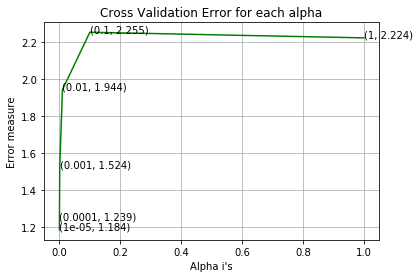

For values of best alpha =  1e-05 The train log loss is: 0.7609550985534874
For values of best alpha =  1e-05 The cv log loss is: 1.1837955128978406
For values of best alpha =  1e-05 The test log loss is: 1.0975823862770926


In [39]:
#Creating list of hyperparameters are [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
alpha = [10 ** i for i in range(-5, 1)]

cv_log_errors = []
for x in alpha:
    clf = SGDClassifier(alpha=x, loss='log', penalty='l2', random_state=42)
    clf.fit(train_text_onehotcoding, y_tr)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_text_onehotcoding, y_tr)
    predict_y = sig_clf.predict_proba(cv_text_onehotcoding)
    cv_log_errors.append(log_loss(y_cv, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', x, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_errors, color='g')
for i, txt in enumerate(np.round(cv_log_errors, 3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_errors[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#training the model with best hyperparameter and finding the train_error, cv_error and test_error
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(alpha=alpha[best_alpha], loss='log', penalty='l2', random_state=42)
clf.fit(train_text_onehotcoding, y_tr)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_text_onehotcoding, y_tr)

#Finding the train error
predict_y = sig_clf.predict_proba(train_text_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))

#cross validation error
predict_y = sig_clf.predict_proba(cv_text_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cv log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

#Test error
predict_y = sig_clf.predict_proba(test_text_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Applying Machine Learning models:

In [165]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

#combining all onehotencoding features
train_gene_var_onehotcoding = hstack((train_gene_onehotcoding, train_var_onehotcoding))
test_gene_var_onehotcoding = hstack((test_gene_onehotcoding, test_var_onehotcoding ))
cv_gene_var_onehotcoding = hstack((cv_gene_onehotcoding, cv_var_onehotcoding))

#to.csr() will return a copy of this matrix in Compressed Sparse Row format
train_x_onehotcoding = hstack((train_gene_var_onehotcoding, train_text_onehotcoding)).tocsr()
train_y = np.array(list(X_tr.Class))

test_x_onehotcoding = hstack((test_gene_var_onehotcoding, test_text_onehotcoding)).tocsr()
test_y = np.array(list(X_test.Class))

cv_x_onehotcoding = hstack((cv_gene_var_onehotcoding, cv_text_onehotcoding)).tocsr()
cv_y = np.array(list(X_cv.Class))

In [41]:
print("onehot encoding features: ")
print("(number of data points * number of features) in train data = ", train_x_onehotcoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotcoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotcoding.shape)

onehot encoding features: 
(number of data points * number of features) in train data =  (2121, 3189)
(number of data points * number of features) in test data =  (664, 3189)
(number of data points * number of features) in cross validation data = (531, 3189)


In [166]:
#Storing gene feature names
gene_features = count_vect.get_feature_names()

#Storing variation feature names
var_features = count_vec_var.get_feature_names()

#Storing Text feature names
text_features = count_vec_text.get_feature_names()

#Combining all feature names into one list
gene_var_text_features = gene_features + var_features + text_features

## Model_1: Naive Bayes:

- Naive bayes is an one the classification algorithm and probability based technique.
- conditional probabilty means that can measures the probability of an event given that another event has occured.
- formula: probability(A/B) = probability(A intersection B) / probability(B)
- Independent events: When two events are said to be independent of each other, what this means is that the probability that one event occurs in no way affects the probability of the other event occurring. 
               
               p(A/B) = p(A) or p(A/B) = p(B)
- Bayes theorem: Describes the probability of an event, based on prior knowledge of conditions that might be related to the event. For example, if cancer is related to age, then, using Bayes’ theorem, a person’s age can be used to more accurately assess the probability that they have cancer, compared to the assessment of the probability of cancer made without knowledge of the person's age.
      
                   p(A/B) = (p(B/A) p(A)) / p(B) which means posterior = (likelihood * prior) / evidence

- Naive Bayes is an algorithm which can uses the bayes theorem to classify the classes, it has assumption means independence betweeen the attributes of datapoints.Popular uses of naive Bayes classifiers include spam filters, text analysis and medical diagnosis
- check this link : http://shatterline.com/blog/2013/09/12/not-so-naive-classification-with-the-naive-bayes-classifier/
- For text classification models naive bayes is considered as an baseline model.
- In naive bayes we should apply the laplace smoothing because suppose for a given query point some words are not present in training data then by that whole should become 0, to avoid that problem will use laplace smoothing.
- In laplace smoothing, a parameter alpha is increased then likelihood probabilities will lead to an "uniform distribution" and alpha is related to an bias-variance-trade off.
- To get read of numerical stability problem will use log probability, which means if we have large dimension then multiplying all probabilities is small value to avoid such problems.
- when alpha is small then model leads to an overfit problem, alpha is large then model leads to underfit problem, so that to best alpha we can use cross validation.
- Feature importance: In case of naive bayes we can get important features using sort the words based on the likelihood probabilities in decending order. high values for likelihood probability of +ve/-ve class then those are the most important features for those classes.
- Interpretability can be done easily by using an probability values.
- There are three types of naive bayes: 

         1. Gaussian naive bayes: It assumes that features are following the normal distribution.
         2. Multinomial naive bayes : It is used for descrete counts in the feature vector.
         3. Bernouli naive bayes : Feature vector values are binary(0 or 1).
- Imbalanced data: Naive bayes can be impacted by imbalaned data by an class priors, to avoid that problem we will convert to an balanced data using upsampling or downsampling.
- outliers: In naive bayes, outliers can be handlied by the laplace smoothing.
- Missing values: 

       1. text feature: No problem with the missing values.
       2. categorical feature : In these case considering NaN is also an one category.
       3. Numerical feature : using an imputation(mean, median etc).
- Similarity matrix (or) distance matrix : It cann't use similarity or distance matrices, it is not an distance based method which means it is an probabilistic based method.
- Large dimension: Naive bayes can work well in large dimension because it extensively used in text data so itself is an large dimension but use log probabilities by that there is no numerical underflow or numerical stability issues.

** Hyperparameter Tuning:**

for alpha 1e-05
Log_loss: 1.2038029145619848
for alpha 0.0001
Log_loss: 1.2037527456995676
for alpha 0.001
Log_loss: 1.203511631992129
for alpha 0.1
Log_loss: 1.2390778470926656
for alpha 1
Log_loss: 1.3661728117336909
for alpha 10
Log_loss: 1.5746234966269372
for alpha 100
Log_loss: 1.5697870606457596
for alpha 1000
Log_loss: 1.5580521070713507


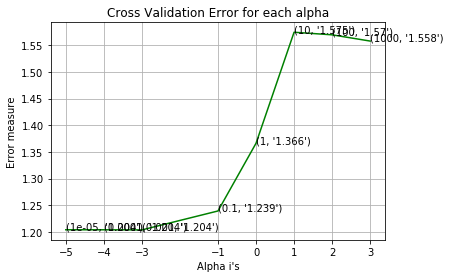

For values of best alpha =  0.001 The train log loss is: 0.5147248501649635
For values of best alpha =  0.001 The cv log loss is: 1.203511631992129
For values of best alpha =  0.001 The test log loss is: 1.1940584766671427


In [42]:
# Defining some range of hyperparameters
alpha_values = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_probs = []
for alpha in alpha_values:
    print("for alpha", alpha)
    clf = MultinomialNB(alpha=alpha)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_probs.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log_loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha_values), cv_log_probs, c='g')
for i, value in enumerate(np.round(cv_log_probs, 3)):
    ax.annotate((alpha_values[i],str(value)), (np.log10(alpha_values[i]),cv_log_probs[i]))
plt.grid()
plt.xticks(np.log10(alpha_values))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#training the model using an best hyperparameter
best_alpha = np.argmin(cv_log_probs)
clf = MultinomialNB(alpha=alpha_values[best_alpha])
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(train_x_onehotcoding, train_y)

#finding the train error, cv error and test error
sig_clf_probs = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The cv log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

sig_clf_probs = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The test log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))


** Testing the model with the best hyperparameter:**

Log_loss: 1.203511631992129
Number of misclassification ponits: 0.3766478342749529
------------------------------ Confusion matrix ------------------------------


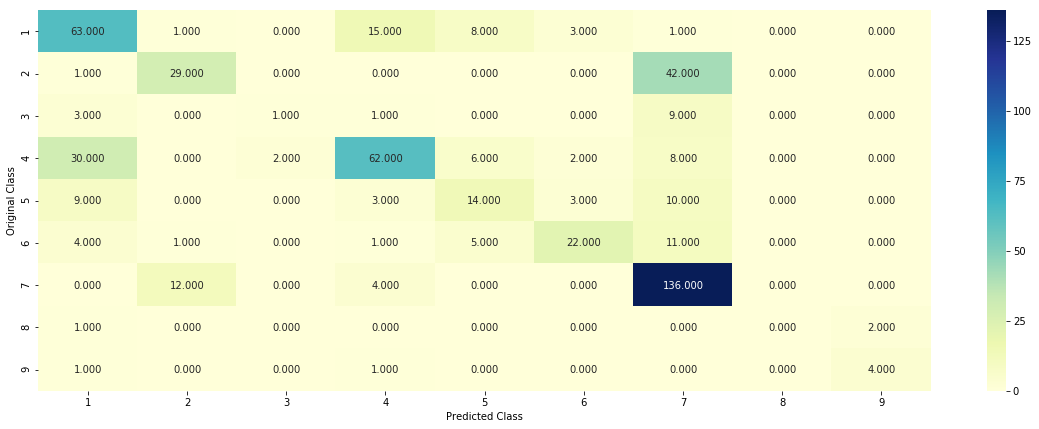

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


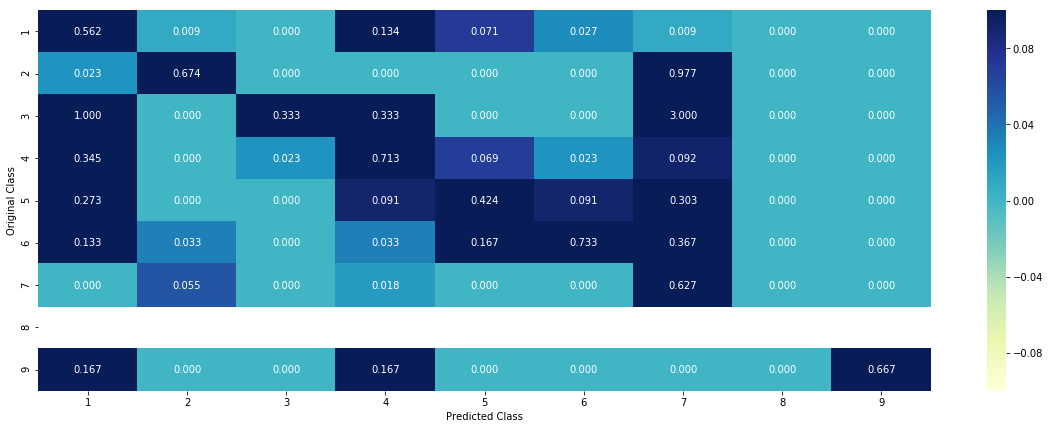

------------------------------ Recall matrix (Row sum=1) ------------------------------


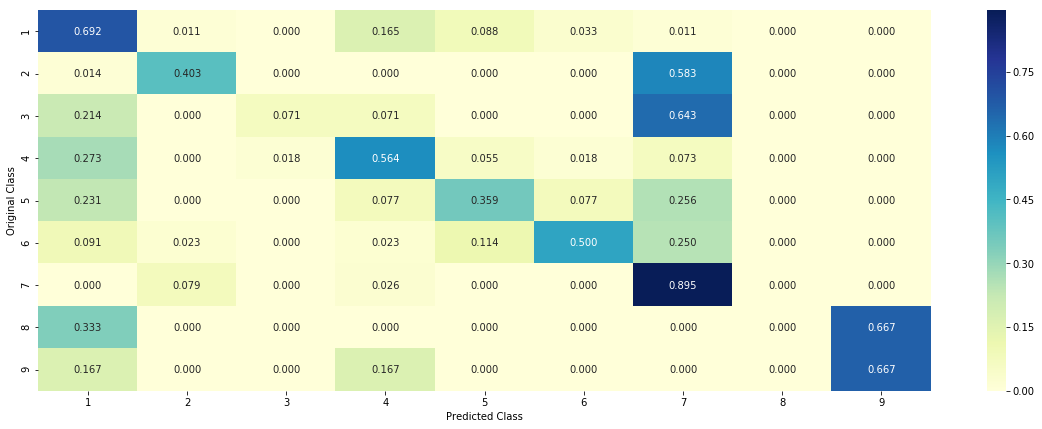

In [104]:
clf = MultinomialNB(alpha=alpha_values[best_alpha])
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(train_x_onehotcoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
print("Log_loss:", log_loss(cv_y, sig_clf_probs))
predict_y = sig_clf.predict(cv_x_onehotcoding)
print("Number of misclassification ponits:",np.count_nonzero(predict_y - cv_y)/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotcoding))

** Top 10 important features for each class:**

In [186]:
#function for to print top 10 important features per each class
def top_10_imp_features(clf):
    for i in range(9):
        indices = np.argsort(-clf.coef_)[i][:10]
        imp_fea = []
        for fea in indices:
            imp_fea.append(gene_var_text_features[fea])
        print("Top 10 important features for Class {} are:".format(i+1), imp_fea)

In [187]:
#Calling function for to print top 10 important features per each class
top_10_imp_features(clf)

Top 10 important features for Class 1 are: ['truncating_mutations', 'tp53', 'brca1', 'deletion', 'tsc2', 'ercc2', 'brca2', 'smad4', 'protein', 'one']
Top 10 important features for Class 2 are: ['egfr', 'kit', 'braf', 'fusions', 'abl1', 'amplification', 'ros1', 'hras', 'pdgfrb', 'pik3ca']
Top 10 important features for Class 3 are: ['brca1', 'mtor', 'pdgfra', 'alk', 'tsc1', 'flt3', 'pten', 'akt1', 'tmprss2', 'mtor']
Top 10 important features for Class 4 are: ['pten', 'tp53', 'brca1', 'cdkn2a', 'vhl', 'tsc2', 'pik3r1', 'spop', 'runx1', 'smad4']
Top 10 important features for Class 5 are: ['brca1', 'brca2', 'fgfr3', 'pik3ca', 'erbb2', 'alk', 'idh1', 'assay', 'variant', 'neutral']
Top 10 important features for Class 6 are: ['brca2', 'brca1', 'jak2', 'odd', 'erbb2', 'tet2', 'basi', 'favor', 'person', 'model']
Top 10 important features for Class 7 are: ['egfr', 'kit', 'alk', 'pdgfra', 'amplification', 'braf', 'flt3', 'kras', 'mtor', 'map2k1']
Top 10 important features for Class 8 are: ['bcor',

In [44]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not

def get_imp_feature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3, max_features=1000)
    
    gene_vec = gene_count_vec.fit(X_tr['Gene'])
    var_vec  = var_count_vec.fit(X_tr['Variation'])
    text_vec = text_count_vec.fit(X_tr['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [45]:
y_test = np.array(y_test)

** Feature importance with Sample point 1: **

In [46]:
test_point_index = 1
no_features = 50
predicted_cls = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("predicted class:", predicted_cls[0])
print("Predicted probabilities:", sig_clf.predict_proba(test_x_onehotcoding[test_point_index]))
print("Actual class:", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls - 1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

predicted class: 2
Predicted probabilities: [[0.0700038  0.48433481 0.01135147 0.08274239 0.03701936 0.03459789
  0.27229902 0.00423165 0.0034196 ]]
Actual class: 2
12 Text feature [patient] present in test data point [True]
16 Text feature [clinic] present in test data point [True]
17 Text feature [respons] present in test data point [True]
18 Text feature [treatment] present in test data point [True]
21 Text feature [therapi] present in test data point [True]
22 Text feature [studi] present in test data point [True]
23 Text feature [month] present in test data point [True]
24 Text feature [mutat] present in test data point [True]
25 Text feature [advanc] present in test data point [True]
26 Text feature [initi] present in test data point [True]
27 Text feature [present] present in test data point [True]
28 Text feature [harbor] present in test data point [True]
29 Text feature [start] present in test data point [True]
30 Text feature [differ] present in test data point [True]
31 Text

** Feature important with Sample point 2: **

In [56]:
test_point_index = 10
no_features = 50
predicted_cls = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("predicted class:", predicted_cls[0])
print("Predicted probabilities:", sig_clf.predict_proba(test_x_onehotcoding[test_point_index]))
print("Actual class:", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls - 1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

predicted class: 7
Predicted probabilities: [[0.05305933 0.05188139 0.01052029 0.09322636 0.03187844 0.02795775
  0.72569179 0.00312116 0.00266349]]
Actual class: 7
16 Text feature [activ] present in test data point [True]
17 Text feature [cell] present in test data point [True]
18 Text feature [presenc] present in test data point [True]
20 Text feature [addit] present in test data point [True]
21 Text feature [kinas] present in test data point [True]
22 Text feature [downstream] present in test data point [True]
23 Text feature [also] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
25 Text feature [increas] present in test data point [True]
26 Text feature [growth] present in test data point [True]
27 Text feature [express] present in test data point [True]
28 Text feature [shown] present in test data point [True]
30 Text feature [mutat] present in test data point [True]
31 Text feature [similar] present in test data point [True]
32 Text

## KNN:

** K-NN: K nearest neighbours: **

- KNN means K-Neighbour neighbours which can store all available cases and classifies new measures based on the similarity measure(e.g., distance functions).

- It can use the Euclidean Distance which means distance between two points.
               
               dis(X,Y) = sqrt(sum(xi - yi)) 
- It works as follows:
               
               1. For an given Query point it can find the all K-nearest neighbours based on the distance.
               2. Find the class labels for k neighbours.
               3. Then give the majority vote among all neighbours class labels.
- Failure cases of KNN:
           
               1. if outliers are present then knn will not work as our expectation.
               2. if data is randomly spread by that we don't get useful information, in that case it will not work well.

- To train knn time is very less but incase of test time is more, so we cann't use for internet applications, stock market etc

- For KNN, K is an hyperparameter so, as K increases then the smoothness of the decision surface will increase.

- But there is some problem as k is very low then leads to overfitting problem(which means training error is low), as K increases then problem of underfit(e.g., suppose if we have 70 +ve points and 30 -ve points if k>=70 then knn will always classifies +ve point eventhough our original Query point is negative.), Train error is high for underfit.

- Advantages:
             
             1. Simple and effective.
             2. Makes no assumptions.
             3. Fast Training phase.
- Disadvantages:
            
             1. Slow Classification Phase(which means testing phase).
             2. Requires lot amount of memory
             3. Nomina features and missing data requires additional processing.

** Hyperparameter Tuning:**

For K_value 1
Log loss: 1.2700730347778841
For K_value 3
Log loss: 1.131560385256402
For K_value 5
Log loss: 1.1316161010179735
For K_value 7
Log loss: 1.149120749363848
For K_value 9
Log loss: 1.1659266259341408
For K_value 11
Log loss: 1.1822035975241634
For K_value 13
Log loss: 1.1908839621044358
For K_value 15
Log loss: 1.1902021707355397
For K_value 17
Log loss: 1.1877174098079741
For K_value 19
Log loss: 1.1923715047269996
For K_value 21
Log loss: 1.2018608920547955
For K_value 23
Log loss: 1.2070167919911383


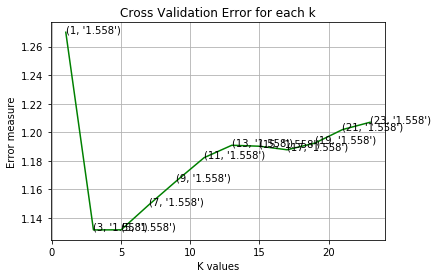

For values of best_k =  3 The train log loss is: 0.8206329875350906
For values of best_k =  3 The cv log loss is: 1.131560385256402
For values of best_k =  3 The test log loss is: 1.1148554812992346
Wall time: 1min 42s


In [47]:
%%time

#Defining some range of k values
k_values = [i for i in range(1,25, 2)]
cv_log_errors = []
for k in k_values:
    print("For K_value", k)
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_errors.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(k_values, cv_log_errors, color='g')
for i, valie in enumerate(np.round(cv_log_errors, 3)):
    ax.annotate((k_values[i], str(value)), (k_values[i], cv_log_errors[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("K values")
plt.ylabel("Error measure")
plt.show()

#Training the model using the best k
best_k = np.argmin(cv_log_errors)
clf = KNeighborsClassifier(n_neighbors=k_values[best_k])
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

#finding the train error
sig_clf_probs = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best_k = ', k_values[best_k], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#finding the cv error
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best_k = ', k_values[best_k], "The cv log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#finding the test error
sig_clf_probs = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best_k = ', k_values[best_k], "The test log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

In [48]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    predict_y = sig_clf.predict(test_x)
    
    #Calculating the log loss
    print("Log loss:", log_loss(test_y, sig_clf.predict_proba(test_x)))
    
    #calculating number of datapoints are mislassified points
    print("Number of misclassified points:", np.count_nonzero(predict_y - test_y)/test_y.shape[0])
    plot_confusion_matrix(test_y, predict_y)

** Testing the model with the best hyperparameter:**

Log loss: 1.131560385256402
Number of misclassified points: 0.3785310734463277
------------------------------ Confusion matrix ------------------------------


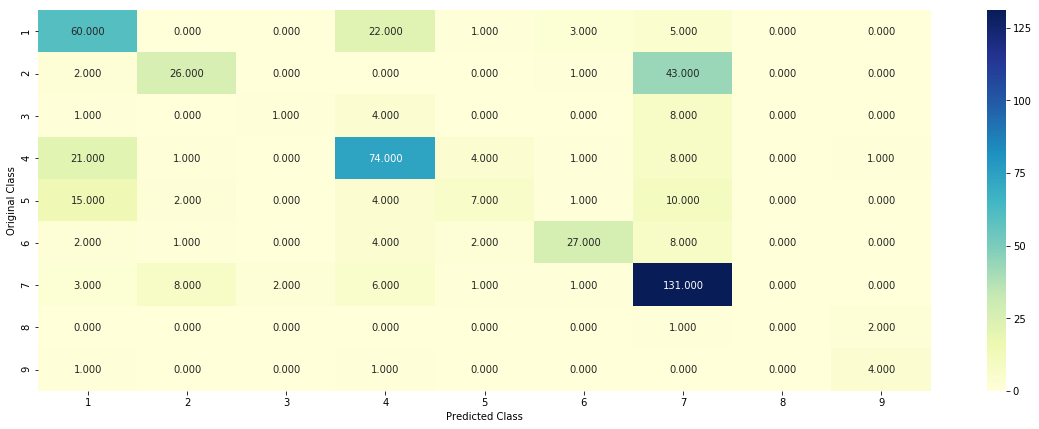

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


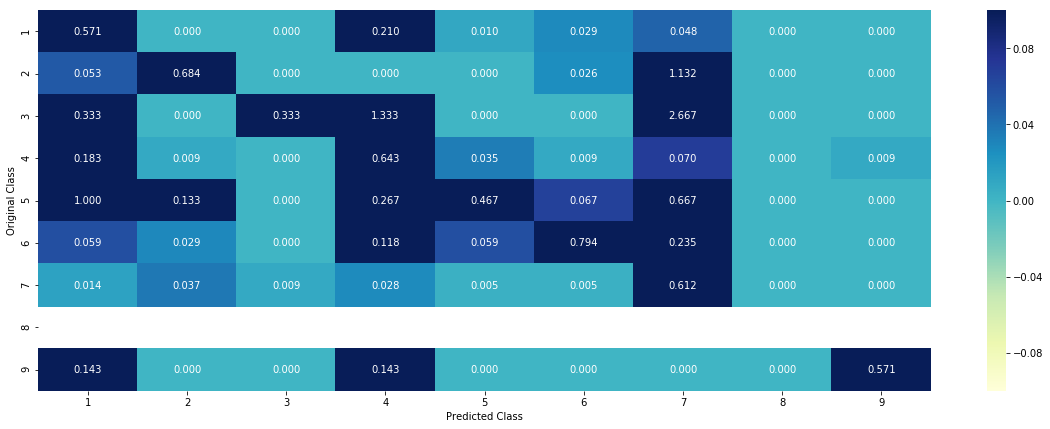

------------------------------ Recall matrix (Row sum=1) ------------------------------


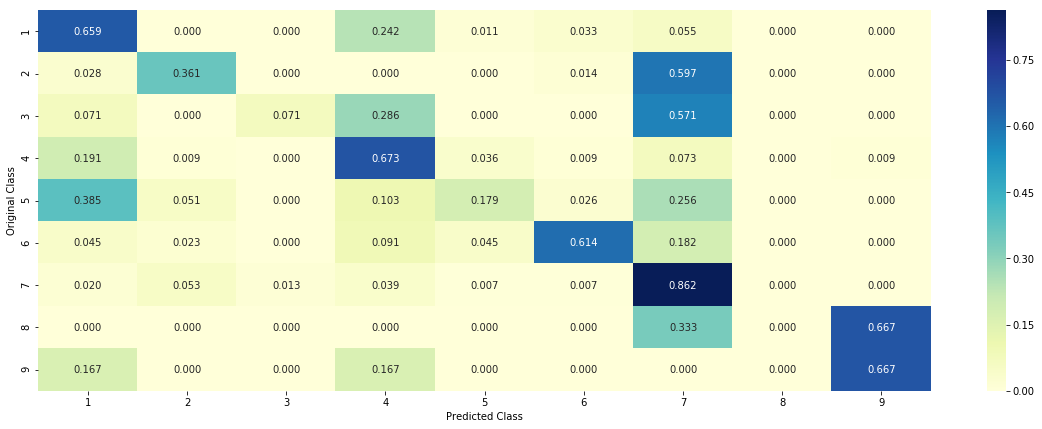

In [49]:
clf = KNeighborsClassifier(n_neighbors=k_values[best_k])
predict_and_plot_confusion_matrix(train_x_onehotcoding, train_y, cv_x_onehotcoding, cv_y, clf)

** Sample point 1:**

In [50]:
clf = KNeighborsClassifier(n_neighbors=k_values[best_k])
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_index = 20
predict_y = sig_clf.predict(test_x_onehotcoding[test_index])
print("Predicted class:", predict_y[0])
print("Actual class:", test_y[test_index])
neighbors = clf.kneighbors(test_x_onehotcoding[test_index], n_neighbors=k_values[best_k])
print("The ",k_values[best_k]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted class: 1
Actual class: 1
The  3  nearest neighbours of the test points belongs to classes [1 1 1]
Fequency of nearest points : Counter({1: 3})


** Sample point 2:**

In [51]:
clf = KNeighborsClassifier(n_neighbors=k_values[best_k])
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_index = 10
predict_y = sig_clf.predict(test_x_onehotcoding[test_index])
print("Predicted class:", predict_y[0])
print("Actual class:", test_y[test_index])
neighbors = clf.kneighbors(test_x_onehotcoding[test_index], n_neighbors=k_values[best_k])
print("The ",k_values[best_k]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted class: 7
Actual class: 7
The  3  nearest neighbours of the test points belongs to classes [7 7 7]
Fequency of nearest points : Counter({7: 3})


## Logistic Regression:

- It is an one of the classification technique, its main aim is saperate different classes using a hyperplane.
- we can find an weight vector which can maximizes the distances of all points from hyperplane.
- it can uses an sigmoid function to get read of outlier problems, so all values should be in the range of 0 to 1.
- In optimization equation we can add log because before adding that should be an non convex shape to converted that into convex shape by that we can find global minima.
- There is concept called regularization which can avoid overfitting and underfitting problem, overfitting means when as complexity of the model increases(model learns more on training data), there is no training error. underfitting means there is an high training error.
- Now here when an weight vector goes to infinite then leads to an overfitting problem to avoid that we can use L1-regularization(it can creates sparsity easily), L2-regularization.
- logistic regression = Loss_function + Regularization term
- In regularization term there is an hyper parameter is lambda, if it is small then leads to overfit, if it is large then leads to underfit.
- feature importance: For that we can check the multicollinearity or pertubation test which means compute the weight vectors, then take data add some small value to each element in the data now compute weight vectors, compare both weight vectors if values are changes significantly then say that features are multicollinear to each other.(collinear means we can find the one feature with the help of other feature.).
- If features are not multicollinear then we can compute important features using an weight vector values and if features are multicollinear then we can find important features using the forward feature selection or backward feature selection.
- Training time for an logistic regression is O(nd), where n is number of points and d is dimensionality for each point , at the end we can store only weight vector which is O(d) so test space is O(d).
- So, this algorithm mostly used in the low latency systems which is mostly used in the internet companies.
- Real world Cases: 

      1. Decision surface is line in 2D, plane in 3D, hyperplane in nD.
      2. Basic assumption is data is linearly separable.
      3. For imbalanced data we can make upsampling or down sampling.
      4. Impact of outliers can be handiled by the sigmoid function, or another way of removing is take data for each point compute distance from plane then points which are far distance from plane remove that points then we get new data(without outliers.)
      5. Missing values can be handiled by the imputation technique.
      6. Multi class can be handiled by the one vs rest.
      7. In case of similarity matrix this algorithm will not work but there is an extension is kernel logistic regression will work.
      8. Best cases: Data is almost linearly separable.
                     Low latency requirement.
                     Very fast to train the data.
      9. If dimensionality is high then there is an chance of getting points are linearly separable is high.
- If data is not linearly separable then we can make it linear separable using some feature engineering techniques.

** With Class balance:**


** Hyperparameter Tuning:**

lambda_value: 1e-06
Log loss: 1.198909578047024
lambda_value: 1e-05
Log loss: 1.1748839635531012
lambda_value: 0.0001
Log loss: 1.09625259555064
lambda_value: 0.001
Log loss: 1.0746365718262842
lambda_value: 0.01
Log loss: 1.1792987565355948
lambda_value: 0.1
Log loss: 1.5926551644432325
lambda_value: 1
Log loss: 1.8423853239952277
lambda_value: 10
Log loss: 1.8685240644744618
lambda_value: 100
Log loss: 1.8714167581647867


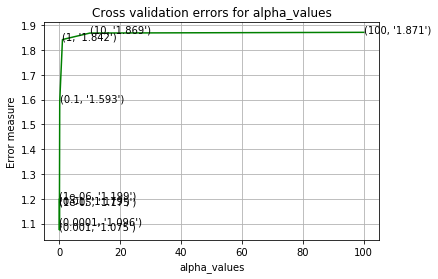

For values of best alpha =  0.001 The train log loss is: 0.6976779727784789
For values of best alpha =  0.001 The cv log loss is: 1.0746365718262842
For values of best alpha =  0.001 The test log loss is: 1.0445892135071828


In [52]:
#Defining some range of lambda values
alpha_values = [10 ** x for x in range(-6, 3)]
cv_log_errors = []
for i in alpha_values:
    print("lambda_value:", i)
    clf = SGDClassifier(loss='log', penalty='l2', alpha=i, class_weight='balanced', random_state=42)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_errors.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha_values, cv_log_errors, c='g')
for i, value in enumerate(np.round(cv_log_errors, 3)):
    ax.annotate((alpha_values[i], str(value)), (alpha_values[i], cv_log_errors[i]))
plt.grid()
plt.title("Cross validation errors for alpha_values")
plt.xlabel("alpha_values")
plt.ylabel("Error measure")
plt.show()

#Training the model with the best hyper parameter
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

#Finding the train error
sig_clf_probs = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the cv error
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The cv log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the test error
sig_clf_probs = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The test log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

** Testing the model with the best hyperparameter:**

Log loss: 1.0746365718262842
Number of misclassified points: 0.3728813559322034
------------------------------ Confusion matrix ------------------------------


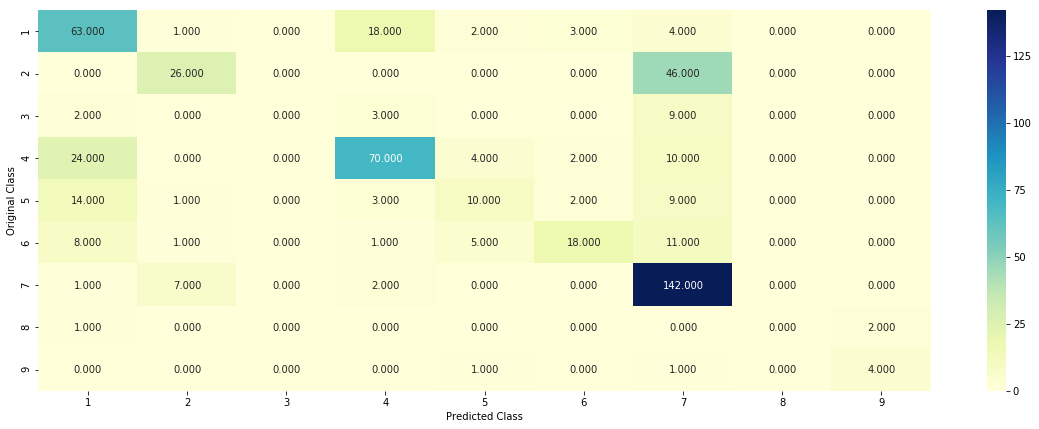

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


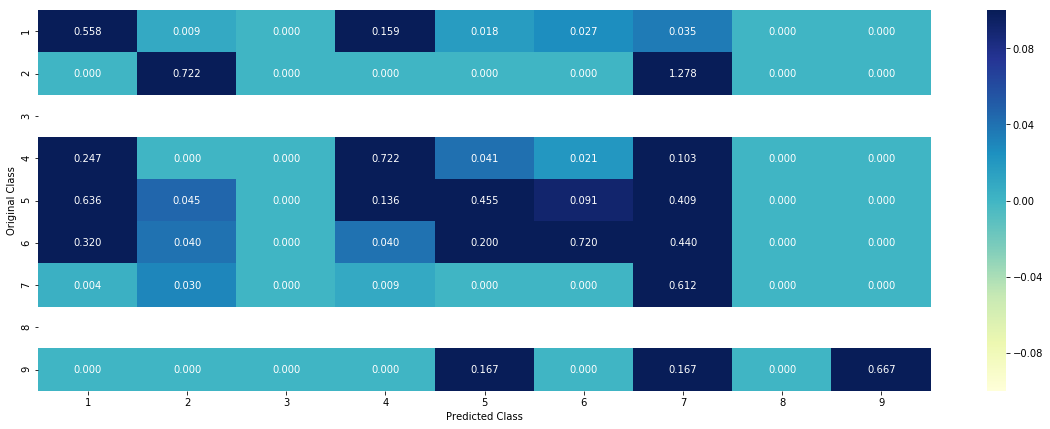

------------------------------ Recall matrix (Row sum=1) ------------------------------


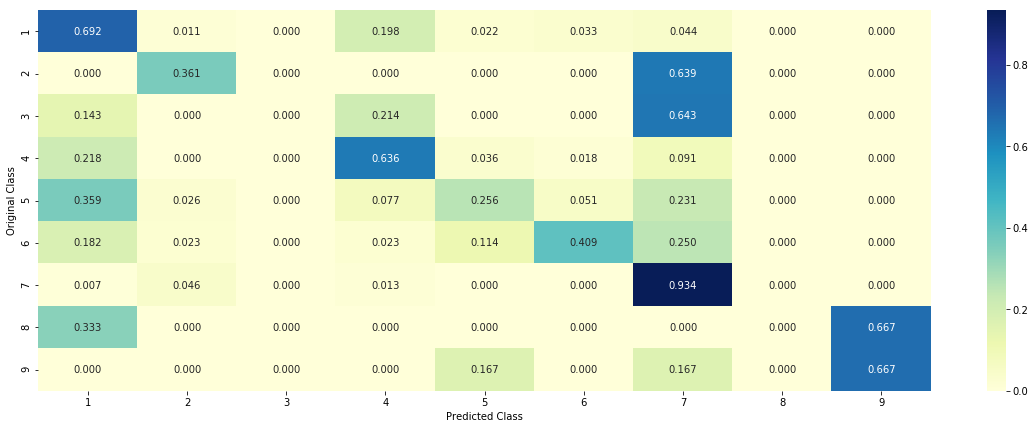

In [53]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotcoding, train_y, cv_x_onehotcoding, cv_y, clf)

** Feature Importance for Sample point 1:**

In [54]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 1
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 2
predicted class probabilities: [[0.007 0.546 0.002 0.012 0.006 0.011 0.413 0.002 0.002]]
Actual Class: 2
23 Text feature [patient] present in test data point [True]
25 Text feature [start] present in test data point [True]
32 Text feature [month] present in test data point [True]
51 Text feature [achiev] present in test data point [True]
60 Text feature [week] present in test data point [True]
127 Text feature [median] present in test data point [True]
128 Text feature [imatinib] present in test data point [True]
144 Text feature [receiv] present in test data point [True]
153 Text feature [step] present in test data point [True]
162 Text feature [therapi] present in test data point [True]
164 Text feature [year] present in test data point [True]
168 Text feature [clinic] present in test data point [True]
179 Text feature [none] present in test data point [True]
180 Text feature [respons] present in test data point [True]
Out of the top  200  features  14 are present 

** Sample point 2:**

In [55]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 11
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 5
predicted class probabilities: [[0.163 0.004 0.22  0.271 0.297 0.042 0.001 0.001 0.001]]
Actual Class: 5
78 Text feature [classif] present in test data point [True]
143 Text feature [quantit] present in test data point [True]
146 Text feature [pathogen] present in test data point [True]
155 Text feature [embryon] present in test data point [True]
159 Text feature [variant] present in test data point [True]
168 Text feature [stem] present in test data point [True]
177 Text feature [classifi] present in test data point [True]
190 Text feature [class] present in test data point [True]
193 Text feature [inform] present in test data point [True]
197 Text feature [vus] present in test data point [True]
198 Text feature [interpret] present in test data point [True]
Out of the top  200  features  11 are present in query point


** With Class Imbalancing:**

** Hyperparameter Tuning:**

lambda_value: 1e-06
Log loss: 1.1886558404916883
lambda_value: 1e-05
Log loss: 1.2056534015361209
lambda_value: 0.0001
Log loss: 1.1384428609065855
lambda_value: 0.001
Log loss: 1.197844224698603
lambda_value: 0.01
Log loss: 1.3137289917511692
lambda_value: 0.1
Log loss: 1.427034299630834
lambda_value: 1
Log loss: 1.6163934389247807
lambda_value: 10
Log loss: 1.6544925744083387
lambda_value: 100
Log loss: 1.6589932125917226


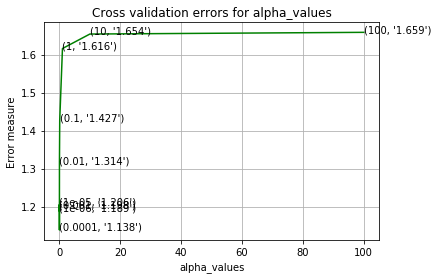

For values of best alpha =  0.0001 The train log loss is: 0.41813972261261645
For values of best alpha =  0.0001 The cv log loss is: 1.1384428609065855
For values of best alpha =  0.0001 The test log loss is: 1.063341024105844


In [56]:
#Defining some range of lambda values
alpha_values = [10 ** x for x in range(-6, 3)]
cv_log_errors = []
for i in alpha_values:
    print("lambda_value:", i)
    clf = SGDClassifier(loss='log', penalty='l2', alpha=i, random_state=42)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_errors.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha_values, cv_log_errors, c='g')
for i, value in enumerate(np.round(cv_log_errors, 3)):
    ax.annotate((alpha_values[i], str(value)), (alpha_values[i], cv_log_errors[i]))
plt.grid()
plt.title("Cross validation errors for alpha_values")
plt.xlabel("alpha_values")
plt.ylabel("Error measure")
plt.show()

#Training the model with the best hyper parameter
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

#Finding the train error
sig_clf_probs = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the cv error
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The cv log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the test error
sig_clf_probs = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The test log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

** Testing the model with the best hyperparameter:**

Log loss: 1.1384428609065855
Number of misclassified points: 0.3502824858757062
------------------------------ Confusion matrix ------------------------------


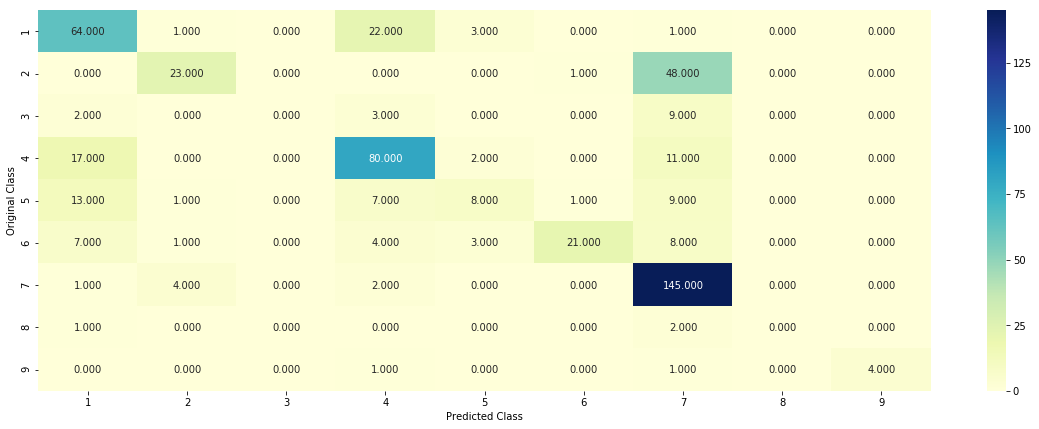

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


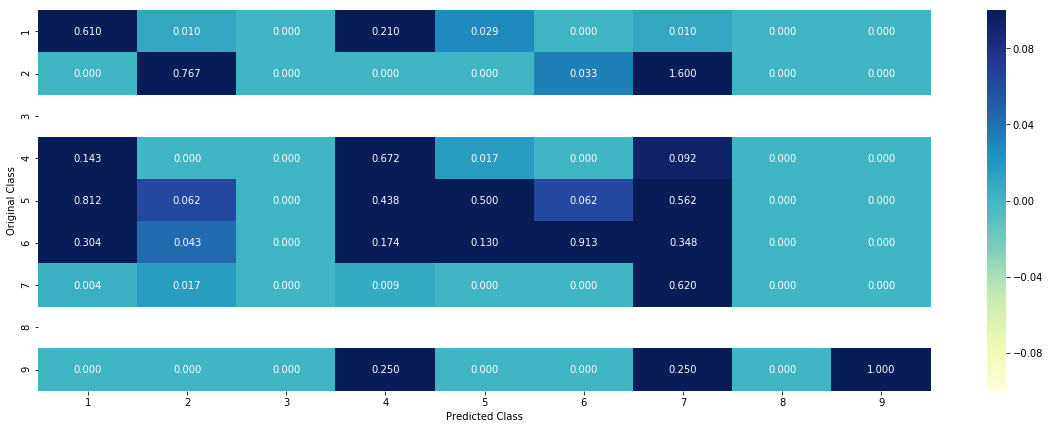

------------------------------ Recall matrix (Row sum=1) ------------------------------


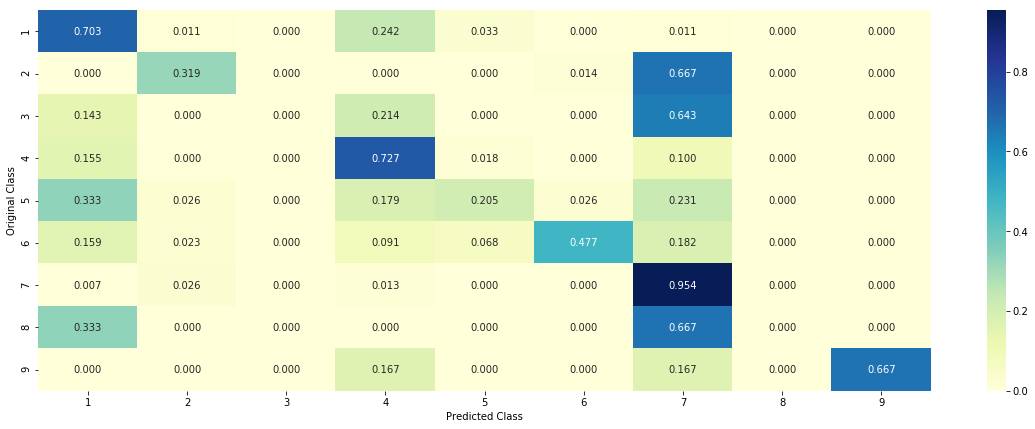

In [57]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotcoding, train_y, cv_x_onehotcoding, cv_y, clf)

** Sample point 1:**

In [58]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 1
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 2
predicted class probabilities: [[0.008 0.555 0.002 0.011 0.004 0.011 0.406 0.002 0.001]]
Actual Class: 2
111 Text feature [none] present in test data point [True]
165 Text feature [rate] present in test data point [True]
176 Text feature [step] present in test data point [True]
193 Text feature [pcr] present in test data point [True]
196 Text feature [rather] present in test data point [True]
197 Text feature [patient] present in test data point [True]
199 Text feature [tissu] present in test data point [True]
Out of the top  200  features  7 are present in query point


** Sample point 2:**

In [59]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 11
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 4
predicted class probabilities: [[0.1   0.006 0.216 0.616 0.055 0.006 0.001 0.001 0.   ]]
Actual Class: 5
115 Text feature [damag] present in test data point [True]
144 Text feature [materi] present in test data point [True]
158 Text feature [intermedi] present in test data point [True]
162 Text feature [repair] present in test data point [True]
184 Text feature [transfect] present in test data point [True]
190 Text feature [recombin] present in test data point [True]
192 Text feature [modifi] present in test data point [True]
Out of the top  200  features  7 are present in query point


## Applying CountVectorizer for text data with unigrams and bigrams:

In [60]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
train_text_uni_bi_onehotcoding = count_vectorizer.fit_transform(X_tr.TEXT)
# we can use the same vectorizer that can be used in train data
cv_text_uni_bi_onehotcoding = count_vectorizer.transform(X_cv.TEXT)
# we can use the same vectorizer that can be used in train data
test_text_uni_bi_onehotcoding = count_vectorizer.transform(X_test.TEXT)

In [61]:
#Combining the features
train_x1_onehotcoding = hstack((train_gene_var_onehotcoding, train_text_uni_bi_onehotcoding)).tocsr()

test_x1_onehotcoding = hstack((test_gene_var_onehotcoding, test_text_uni_bi_onehotcoding)).tocsr()

cv_x1_onehotcoding = hstack((cv_gene_var_onehotcoding, cv_text_uni_bi_onehotcoding)).tocsr()

In [62]:
print("Number of datapoints:", train_x1_onehotcoding.shape[0])
print("Number of features in train data:", train_x1_onehotcoding.shape[1])

Number of datapoints: 2121
Number of features in train data: 1090940


lambda_value: 1e-06
Log loss: 1.8315841517469778
lambda_value: 1e-05
Log loss: 1.7686768122837084
lambda_value: 0.0001
Log loss: 1.2986172373530072
lambda_value: 0.001
Log loss: 1.2645054457324594
lambda_value: 0.01
Log loss: 1.2747348911287244
lambda_value: 0.1
Log loss: 1.2690879579101848
lambda_value: 1
Log loss: 1.2443569364025746
lambda_value: 10
Log loss: 1.1888538974881955
lambda_value: 100
Log loss: 1.3814289227047616


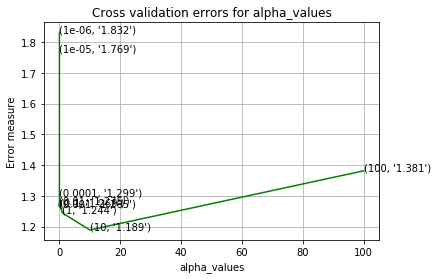

For values of best alpha =  10 The train log loss is: 0.9672291811669181
For values of best alpha =  10 The cv log loss is: 1.1888538974881955
For values of best alpha =  10 The test log loss is: 1.2077924510277829
Wall time: 5min 6s


In [63]:

%%time

#Defining some range of lambda values
alpha_values = [10 ** x for x in range(-6, 3)]
cv_log_errors = []
for i in alpha_values:
    print("lambda_value:", i)
    clf = SGDClassifier(loss='log', penalty='l2', alpha=i, class_weight='balanced', random_state=42)
    clf.fit(train_x1_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x1_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x1_onehotcoding)
    cv_log_errors.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha_values, cv_log_errors, c='g')
for i, value in enumerate(np.round(cv_log_errors, 3)):
    ax.annotate((alpha_values[i], str(value)), (alpha_values[i], cv_log_errors[i]))
plt.grid()
plt.title("Cross validation errors for alpha_values")
plt.xlabel("alpha_values")
plt.ylabel("Error measure")
plt.show()

#Training the model with the best hyper parameter
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x1_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x1_onehotcoding, train_y)

#Finding the train error
sig_clf_probs = sig_clf.predict_proba(train_x1_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the cv error
sig_clf_probs = sig_clf.predict_proba(cv_x1_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The cv log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the test error
sig_clf_probs = sig_clf.predict_proba(test_x1_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The test log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

** Testing the model with the best hyperparameter:**

Log loss: 1.1888538974881955
Number of misclassified points: 0.4030131826741996
------------------------------ Confusion matrix ------------------------------


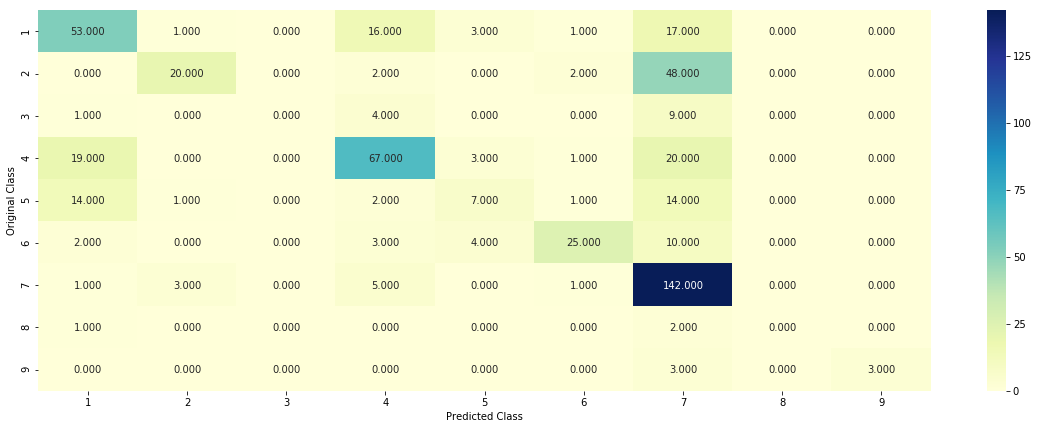

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


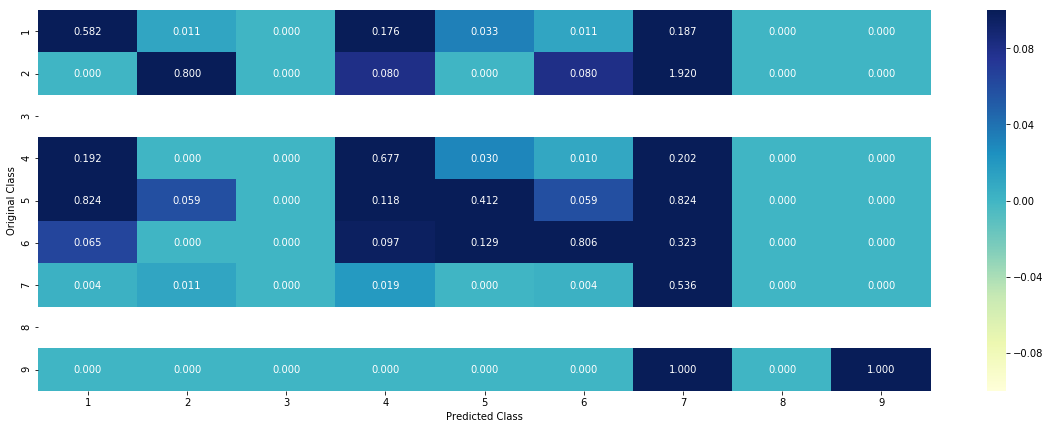

------------------------------ Recall matrix (Row sum=1) ------------------------------


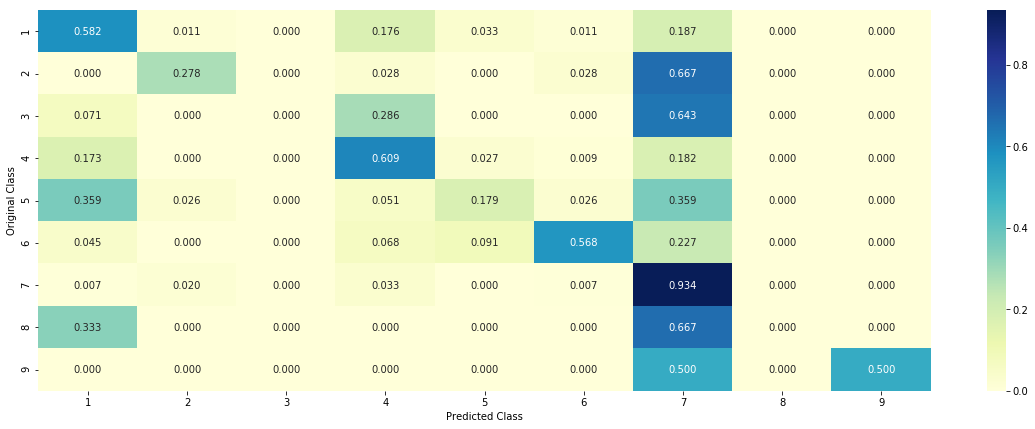

In [64]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
predict_and_plot_confusion_matrix(train_x1_onehotcoding, train_y, cv_x1_onehotcoding, cv_y, clf)

** Sample point 1:**

In [65]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x1_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x1_onehotcoding, train_y)

test_point_index = 11
no_features = 100
predict_y = sig_clf.predict(test_x1_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x1_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])

Predicted class: 4
predicted class probabilities: [[0.232 0.05  0.15  0.327 0.129 0.042 0.058 0.005 0.007]]
Actual Class: 5


** Sample point 2:**

In [66]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x1_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x1_onehotcoding, train_y)

test_point_index = 10
no_features = 200
predict_y = sig_clf.predict(test_x1_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x1_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])

Predicted class: 7
predicted class probabilities: [[0.069 0.282 0.013 0.054 0.023 0.023 0.527 0.005 0.004]]
Actual Class: 7


## Linear SVM:

- A support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin).
- The support vectors are those data points that lie (exactly) on the borders of the margins or support vector planes. 
- Key idea of svm is Hyperplane that saperates +ve points and -ve points as widely as possible.
- SVM will try to find best hyperplane(maximum margin hyperplane) that maximiizes the margin.
- Hard margin svm does not consisting of loss term(which means no geta i), but incase of soft margin svm consisting of loss term (in these case C is an hyperparameter as C increases tendency to make mistakes on train data decreases then leads to overfitting and as C decreases tendency to make mistakes on train data increases then leads to underfitting. ( so, C means 1/lambda )
- For an svm loss should be an hinge loss those loss values range of -infinite to 1, for correctly classified points hinge loss should be zero and for misclassified points hinge loss should be 1-distance of misclassified point.
- Dual form svm consisting of an kernel function, In an dual form if do not apply kernel trick just leaving xi transpose xj then it is called Linear svm and if we apply kernel trick k(xi, xj) then it is called kernel svm.
- Note: if data is non linear:

                              1. Linear svm will fail.
                              2. Logistic regression will fail because no hyperplane cannot saperate non linear data.
                              3. But Logistic regression + feature engineering will handle.
                              4. Kernel svm willalso handle.(in these cases transformation can be done internally)
- one of the most popular kernel is RBF (radial basis function) kernel, it consisting of two hyperparameters are C and alpha.
- In case of kernel svm time complexity is O(n^2).
- svm for classification means svc and svm for regression means svr.
- Cases:
 
       1. Feature Engineering: In these case kernel trick can be done internally.
       2. Decision surface: hyperplane
       3. similarity matrix: works well because kernel trick handles.
       4. feature importance: For kernel svm feature importance and interpretability is hard but linear svm is same as logistic regression.
       5. outliers: Incase of svm outliers are less impact.
       6. Large dimension: Is good for svm
       7. wort case: when data is large then time taken is high.

** Hyperparameter Tuning:**

Alpha value 1e-06
Log loss: 1.185211453125472
Alpha value 1e-05
Log loss: 1.1559756048123204
Alpha value 0.0001
Log loss: 1.131120507864348
Alpha value 0.001
Log loss: 1.1045443646236468
Alpha value 0.01
Log loss: 1.3740669600923072
Alpha value 0.1
Log loss: 1.5952846476063585
Alpha value 1
Log loss: 1.872048548091512
Alpha value 10
Log loss: 1.872042204456266
Alpha value 100
Log loss: 1.8720485676371725


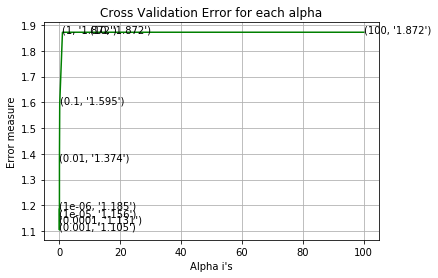

For values of best alpha =  0.001 The train log loss is: 0.5697794871020693
For values of best alpha =  0.001 The train log loss is: 1.1045443646236468
For values of best alpha =  0.001 The train log loss is: 1.0730635028881452


In [68]:
#Defining some range of parameters 
alpha_values = [10 ** x for x in range(-6, 3)]
cv_log_errors = []
for i in alpha_values:
    print("Alpha value", i)
    #clf = SVC(C=i, kernel='linear', class_weight='balanced')
    clf = SGDClassifier(loss='hinge', penalty='l2', alpha=i, random_state=42, class_weight='balanced')
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_errors.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha_values, cv_log_errors, c='g')
for i, value in enumerate(np.round(cv_log_errors, 3)):
    ax.annotate((alpha_values[i], str(value)), (alpha_values[i], cv_log_errors[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#Training the model with the best hyper parameter
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

#Finding the train error
sig_clf_probs = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the cv error
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the test error
sig_clf_probs = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

** Testing the model with the best hyperparameter:**

Log loss: 1.1045443646236468
Number of misclassified points: 0.3502824858757062
------------------------------ Confusion matrix ------------------------------


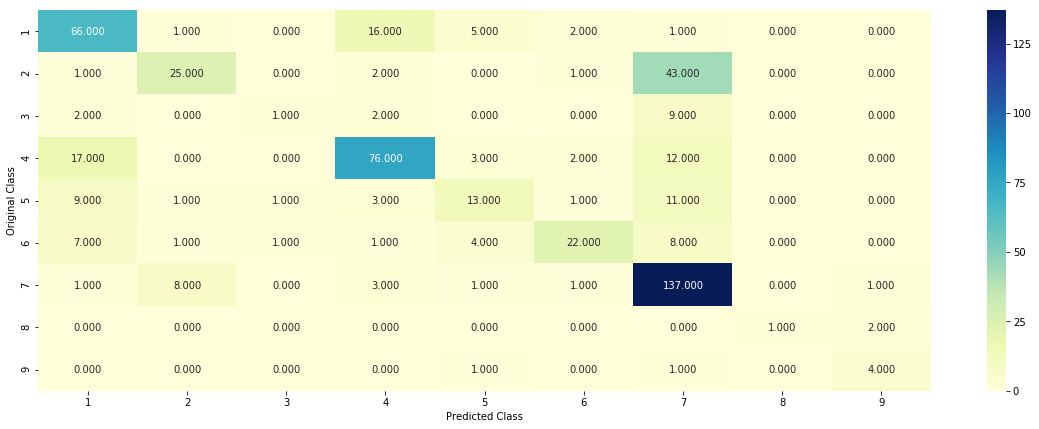

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


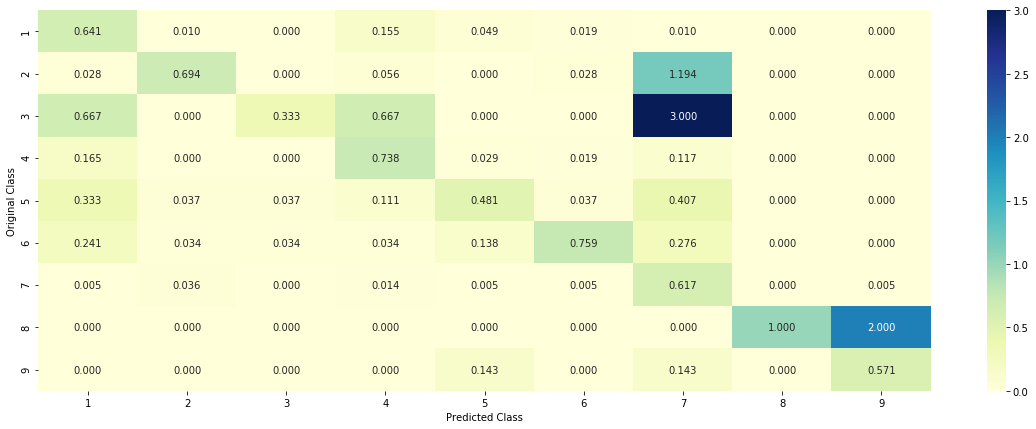

------------------------------ Recall matrix (Row sum=1) ------------------------------


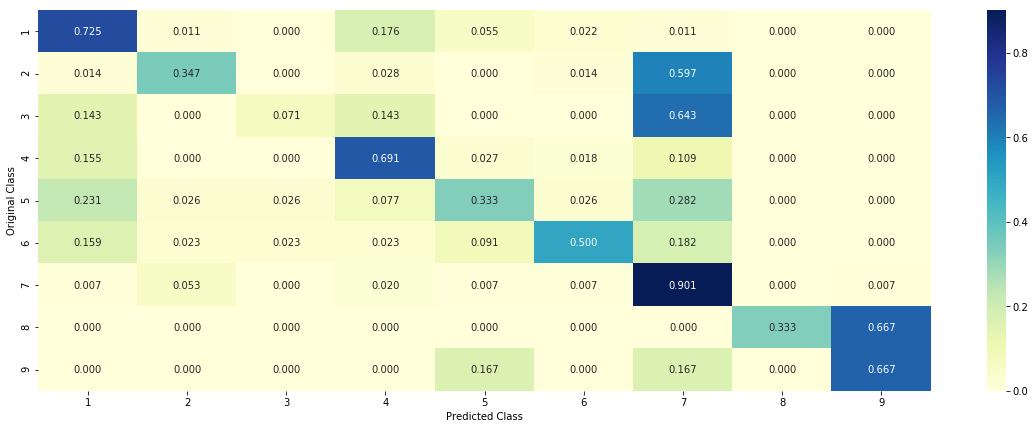

In [69]:
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotcoding, train_y, cv_x_onehotcoding, cv_y, clf)

** Feature importance Sample point 1 : **

In [70]:
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 10
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 7
predicted class probabilities: [[0.012 0.049 0.    0.023 0.006 0.001 0.907 0.    0.001]]
Actual Class: 7
13 Text feature [constitut] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [enhanc] present in test data point [True]
22 Text feature [minut] present in test data point [True]
28 Text feature [autophosphoryl] present in test data point [True]
29 Text feature [hour] present in test data point [True]
30 Text feature [serum] present in test data point [True]
31 Text feature [intrins] present in test data point [True]
35 Text feature [marrow] present in test data point [True]
51 Text feature [institut] present in test data point [True]
53 Text feature [bone] present in test data point [True]
56 Text feature [transform] present in test data point [True]
57 Text feature [leukemia] present in test data point [True]
60 Text feature [absenc] present in test data point [True]
63 Text feature [hybrid] present 

** Sample point 2:**

In [71]:
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 100
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 6
predicted class probabilities: [[0.037 0.012 0.012 0.09  0.002 0.828 0.017 0.001 0.001]]
Actual Class: 6
2 Text feature [ligas] present in test data point [True]
4 Text feature [expect] present in test data point [True]
6 Text feature [substitut] present in test data point [True]
89 Text feature [ring] present in test data point [True]
90 Text feature [random] present in test data point [True]
95 Text feature [interact] present in test data point [True]
96 Text feature [prevent] present in test data point [True]
97 Text feature [person] present in test data point [True]
98 Text feature [suppress] present in test data point [True]
109 Text feature [femal] present in test data point [True]
110 Text feature [confer] present in test data point [True]
111 Text feature [concentr] present in test data point [True]
112 Text feature [ubiquitin] present in test data point [True]
113 Text feature [resist] present in test data point [True]
117 Text feature [certain] present in t

## Random Forest:

- Random Forest is an one of the bagging model which means an ensemble model.
- Bagging also called as Bootstrap sampling which means take training data divide into sample subsets then each subset will train on different model and combine as one model.
- The main aim of bagging model is suppose if a model has high variance and low bias then bagging will do as reducing the variance and keep low bias. so bagging will reduce the variance.
- Example: Decision tree has high variance and low bias when depth increases.
- Random Forest means a forest has lots of trees and random comes from bootstrap sampling(also often called as row sampling).
- Random Forest means taking decision tree as base learners + row sampling with replacement + column sampling + Aggregation.
- So, random forest will decreases the variance, in these as number of trees increases then variance will decrease and number of trees decreases then variance will increases.
- we know that as dimension increases then decision tree will not handle, so random forest is also will not handle in case of large dimension. properties of decision tree and random forest is same but incase of bias_varaince_tradeoff and feature importance. 
- Random forest will not work well at especially categorical features with many categories and large dimension.

** It consist of two hyperparameters are alpha( number of tree's) and max_depth of each tree:**

In [72]:

%%time

alpha_values = [100, 200, 500, 1000, 2000]
max_depth = [5, 10]
cv_log_errors = []
for alpha in alpha_values:
    for depth in max_depth:
        print("For n_estimators=", alpha,  "and max_depth=", depth)
        clf = RandomForestClassifier(n_estimators=alpha, criterion='gini',  max_depth=depth, random_state=42, n_jobs=3)
        clf.fit(train_x_onehotcoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotcoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
        cv_log_errors.append(log_loss(cv_y, sig_clf_probs))
        print("Log loss:", log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Training the model using the best hyperparameter
best_params = np.argmin(cv_log_errors)
clf = RandomForestClassifier(n_estimators=alpha_values[int(best_params/2)], criterion='gini',  max_depth=max_depth[int(best_params%2)], random_state=42, n_jobs=3)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

#finding the train error
sig_clf_probs = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best estimator = ', alpha_values[int(best_params/2)], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#finding the cv error
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best estimator = ', alpha_values[int(best_params/2)], "The cv log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#finding the test error
sig_clf_probs = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best estimator = ', alpha_values[int(best_params/2)], "The test log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))


For n_estimators= 100 and max_depth= 5
Log loss: 1.2276894918147205
For n_estimators= 100 and max_depth= 10
Log loss: 1.2777235947242491
For n_estimators= 200 and max_depth= 5
Log loss: 1.2102742219988047
For n_estimators= 200 and max_depth= 10
Log loss: 1.259991520791285
For n_estimators= 500 and max_depth= 5
Log loss: 1.2060689234361421
For n_estimators= 500 and max_depth= 10
Log loss: 1.2545781962834923
For n_estimators= 1000 and max_depth= 5
Log loss: 1.2049972209704876
For n_estimators= 1000 and max_depth= 10
Log loss: 1.250725089450797
For n_estimators= 2000 and max_depth= 5
Log loss: 1.203855704549852
For n_estimators= 2000 and max_depth= 10
Log loss: 1.2481572297005312
For values of best estimator =  2000 The train log loss is: 0.86249533551532
For values of best estimator =  2000 The cv log loss is: 1.203855704549852
For values of best estimator =  2000 The test log loss is: 1.1951831724537407
Wall time: 9min 51s


** Testing the model with the best hyperparmeter:**

Log loss: 1.203855704549852
Number of misclassified points: 0.4369114877589454
------------------------------ Confusion matrix ------------------------------


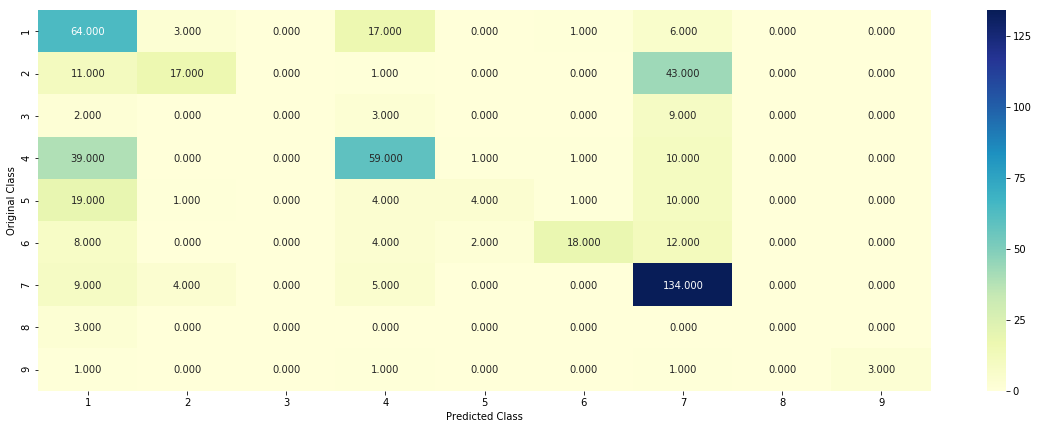

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


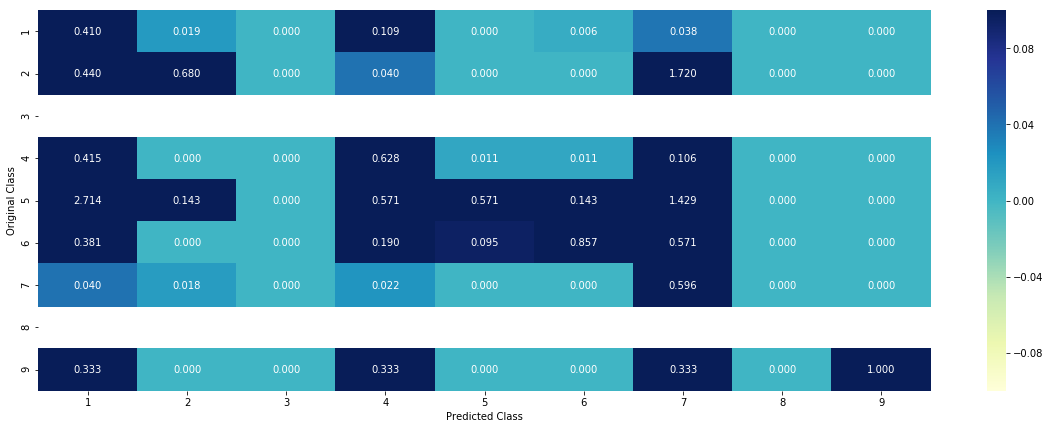

------------------------------ Recall matrix (Row sum=1) ------------------------------


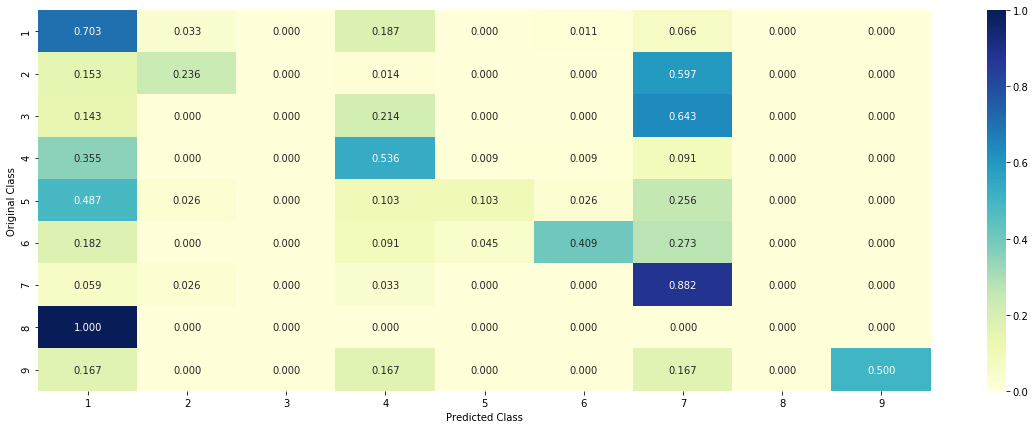

In [73]:
clf = RandomForestClassifier(n_estimators=alpha_values[int(best_params/2)], criterion='gini',  max_depth=max_depth[int(best_params%2)], random_state=42, n_jobs=3)
predict_and_plot_confusion_matrix(train_x_onehotcoding, train_y, cv_x_onehotcoding, cv_y, clf)

** Sample point 1: **

In [74]:
clf = RandomForestClassifier(n_estimators=alpha_values[int(best_params/2)], criterion='gini',  max_depth=max_depth[int(best_params%2)], random_state=42, n_jobs=3)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 100
no_features = 100
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
get_imp_feature_names(indices[:no_features], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 6
predicted class probabilities: [[0.087 0.01  0.009 0.087 0.052 0.734 0.016 0.003 0.002]]
Actual Class: 6
0 Text feature [kinas] present in test data point [True]
1 Text feature [function] present in test data point [True]
2 Text feature [tyrosin] present in test data point [True]
3 Text feature [inhibitor] present in test data point [True]
4 Text feature [suppressor] present in test data point [True]
5 Text feature [missens] present in test data point [True]
6 Text feature [oncogen] present in test data point [True]
7 Text feature [protein] present in test data point [True]
9 Text feature [therapeut] present in test data point [True]
10 Text feature [inactiv] present in test data point [True]
12 Text feature [phosphoryl] present in test data point [True]
13 Text feature [nonsens] present in test data point [True]
14 Text feature [loss] present in test data point [True]
15 Text feature [truncat] present in test data point [True]
16 Text feature [defect] present in tes

** Sample point 2:**

In [75]:
clf = RandomForestClassifier(n_estimators=alpha_values[int(best_params/2)], criterion='gini',  max_depth=max_depth[int(best_params%2)], random_state=42, n_jobs=3)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 10
no_features = 100
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
get_imp_feature_names(indices[:no_features], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 7
predicted class probabilities: [[0.042 0.253 0.016 0.031 0.043 0.044 0.562 0.007 0.003]]
Actual Class: 7
0 Text feature [kinas] present in test data point [True]
1 Text feature [function] present in test data point [True]
2 Text feature [tyrosin] present in test data point [True]
3 Text feature [inhibitor] present in test data point [True]
7 Text feature [protein] present in test data point [True]
8 Text feature [treatment] present in test data point [True]
9 Text feature [therapeut] present in test data point [True]
11 Text feature [receptor] present in test data point [True]
12 Text feature [phosphoryl] present in test data point [True]
14 Text feature [loss] present in test data point [True]
18 Text feature [variant] present in test data point [True]
19 Text feature [erk] present in test data point [True]
22 Text feature [constitut] present in test data point [True]
23 Text feature [growth] present in test data point [True]
24 Text feature [therapi] present in tes

# Stacking Models:

- Refer this link https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
- Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

In [76]:
#logistic Regression
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotcoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

#Linear SVM
clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotcoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

#Multinomial Naive Bayes
clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotcoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotcoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotcoding))))
sig_clf2.fit(train_x_onehotcoding, train_y)
print("Linear SVM: log loss:%0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotcoding))))
sig_clf3.fit(train_x_onehotcoding, train_y)
print("Multinomial Naive Bayes: log loss:%0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotcoding))))

print("*"*40)
alpha_values = [0.0001,0.001,0.01,0.1,1,10]
cv_log_error = []
for i in alpha_values:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotcoding, train_y)
    print("Stacking Classifer : for the value of alpha:", i, "Log Loss:%0.3f" % (log_loss(cv_y, sclf.predict_proba(cv_x_onehotcoding))))
    cv_log_error.append(log_loss(cv_y, sclf.predict_proba(cv_x_onehotcoding)))

Logistic Regression :  Log Loss: 1.10
Linear SVM: log loss:1.11
Multinomial Naive Bayes: log loss:1.20
****************************************
Stacking Classifer : for the value of alpha: 0.0001 Log Loss:2.171
Stacking Classifer : for the value of alpha: 0.001 Log Loss:1.978
Stacking Classifer : for the value of alpha: 0.01 Log Loss:1.388
Stacking Classifer : for the value of alpha: 0.1 Log Loss:1.179
Stacking Classifer : for the value of alpha: 1 Log Loss:1.476
Stacking Classifer : for the value of alpha: 10 Log Loss:1.976


** Testing the model with the best hyperparameter:**

Log loss (train) on the stacking classifier : 0.330
Log loss (cv) on the stacking classifier : 1.179
Log loss (test) on the stacking classifier : 1.119
Number of misclassified points:0.348
------------------------------ Confusion matrix ------------------------------


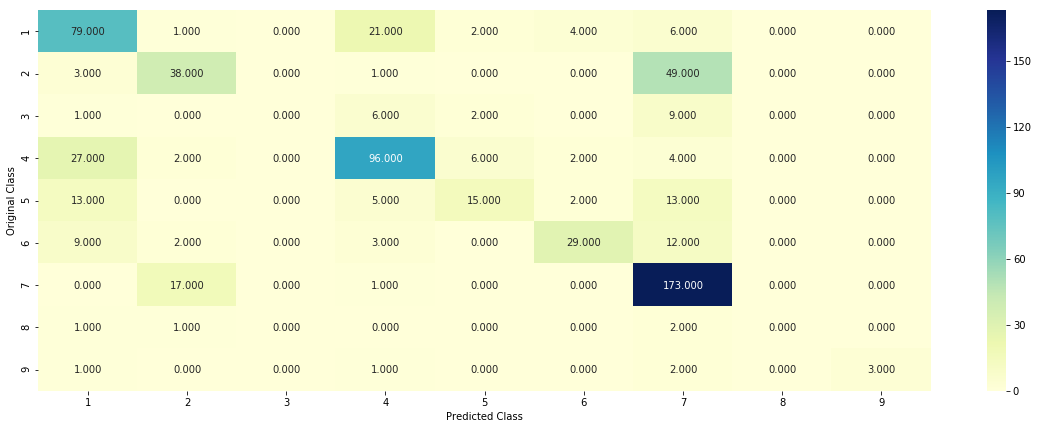

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


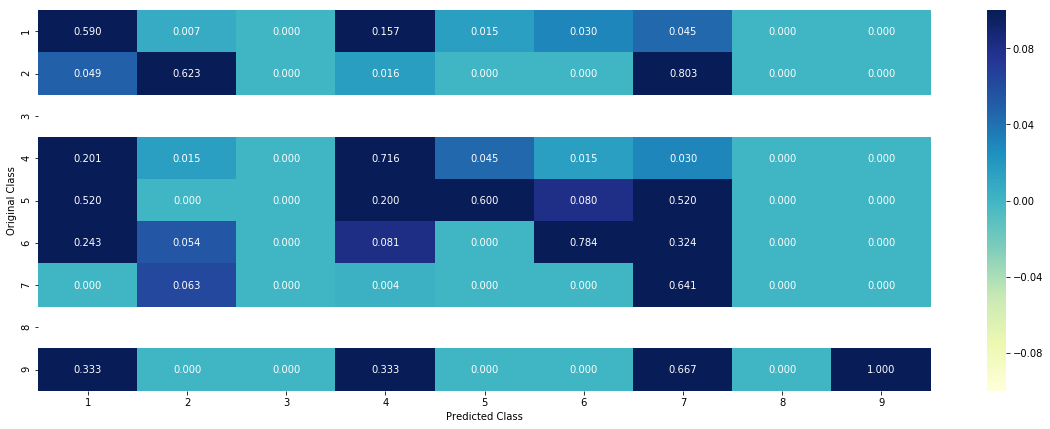

------------------------------ Recall matrix (Row sum=1) ------------------------------


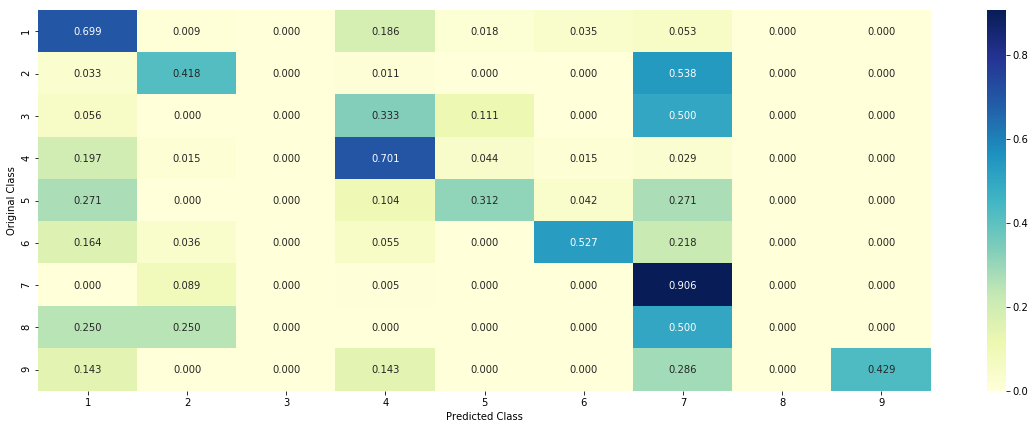

In [77]:
best_alpha = np.argmin(cv_log_error)
lr = LogisticRegression(C=alpha_values[best_alpha])
sclf =  StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotcoding, train_y)

#finding the train error
print("Log loss (train) on the stacking classifier : %0.3f" % (log_loss(train_y, sclf.predict_proba(train_x_onehotcoding))))

#finding the cv error
print("Log loss (cv) on the stacking classifier : %0.3f" % (log_loss(cv_y, sclf.predict_proba(cv_x_onehotcoding))))

#finding the test error
print("Log loss (test) on the stacking classifier : %0.3f" % (log_loss(test_y, sclf.predict_proba(test_x_onehotcoding))))

print("Number of misclassified points:%0.3f" % (np.count_nonzero(sclf.predict(test_x_onehotcoding) - test_y) / test_y.shape[0]))
plot_confusion_matrix(test_y, sclf.predict(test_x_onehotcoding))

# Maximum Voting  Classifier:

- It is an one of the ensemble model which means for training data run different models, suppose for label x all models predicts from that taking the majority vote.

Log loss (train) on the VotingClassifier : 0.46672259029359525
Log loss (CV) on the VotingClassifier : 1.0769676257447456
Log loss (test) on the VotingClassifier : 1.045474776843367
Number of missclassified point : 0.3433734939759036
------------------------------ Confusion matrix ------------------------------


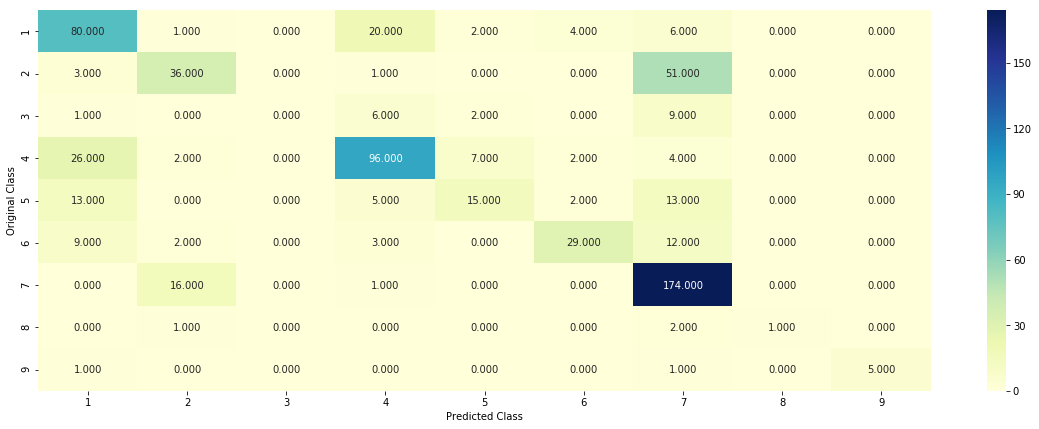

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


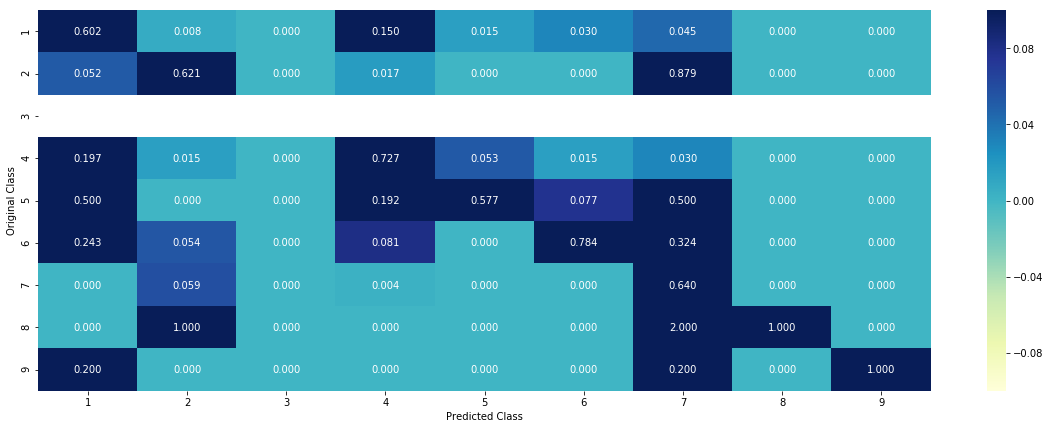

------------------------------ Recall matrix (Row sum=1) ------------------------------


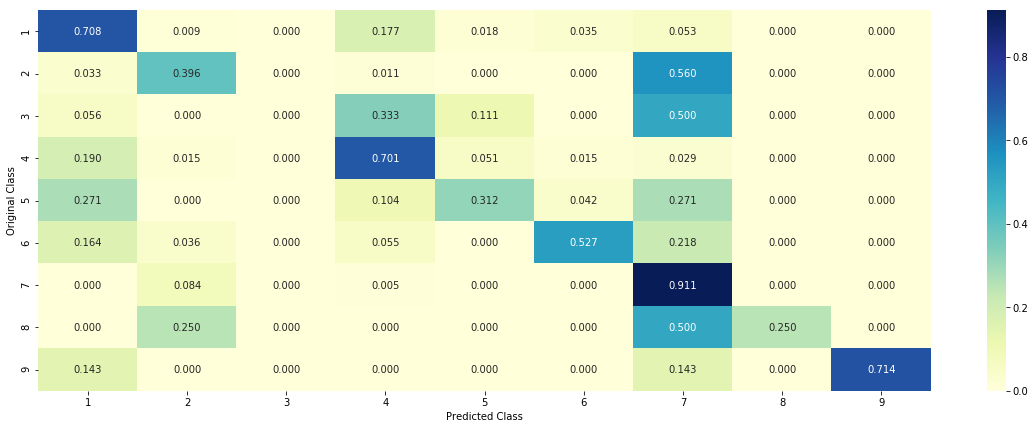

In [78]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svm', sig_clf2), ('nv', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotcoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotcoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotcoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotcoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotcoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, vclf.predict(test_x_onehotcoding))

## Reducing the test log loss using best model :

In [94]:

%%time

#onehotencoding for text feature
#Taking the top most important features 
count_vec_text = TfidfVectorizer(min_df=5, max_features=5000)
train_text_onehotcoding = count_vec_text.fit_transform(X_tr.TEXT)
#normalizing the train data and axis=0 means normalize based on the features
train_text_onehotcoding = normalize(train_text_onehotcoding, axis=0)

# we can use the same vectorizer that can be used in train data
cv_text_onehotcoding = count_vec_text.transform(X_cv.TEXT)
#normalizing the cv data
cv_text_onehotcoding = normalize(cv_text_onehotcoding, axis=0)

test_text_onehotcoding = count_vec_text.transform(X_test.TEXT)
test_text_onehotcoding = normalize(test_text_onehotcoding, axis=0)

Wall time: 1min 3s


In [95]:
#Combining the features
train_x3_onehotcoding = hstack((train_gene_var_onehotcoding, train_text_onehotcoding)).tocsr()

test_x3_onehotcoding = hstack((test_gene_var_onehotcoding, test_text_onehotcoding)).tocsr()


cv_x3_onehotcoding = hstack((cv_gene_var_onehotcoding, cv_text_onehotcoding)).tocsr()

lambda_value: 1e-06
Log loss: 1.1349223930383292
lambda_value: 1e-05
Log loss: 1.1323356510928968
lambda_value: 0.0001
Log loss: 1.036053141599388
lambda_value: 0.001
Log loss: 1.0396766329495801
lambda_value: 0.01
Log loss: 1.106380837834641
lambda_value: 0.1
Log loss: 1.4824183072378527
lambda_value: 1
Log loss: 1.6857479743695702
lambda_value: 10
Log loss: 1.7096803521702773
lambda_value: 100
Log loss: 1.7123217341577588


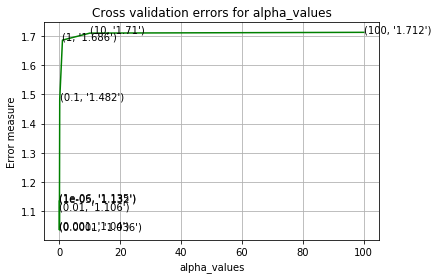

For values of best alpha =  0.0001 The train log loss is: 0.4189841101351649
For values of best alpha =  0.0001 The cv log loss is: 1.036053141599388
For values of best alpha =  0.0001 The test log loss is: 0.9889368699522173


In [96]:
#Defining some range of lambda values
alpha_values = [10 ** x for x in range(-6, 3)]
cv_log_errors = []
for i in alpha_values:
    print("lambda_value:", i)
    clf = SGDClassifier(loss='log', penalty='l2', alpha=i, class_weight='balanced', random_state=42)
    clf.fit(train_x3_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x3_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x3_onehotcoding)
    cv_log_errors.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha_values, cv_log_errors, c='g')
for i, value in enumerate(np.round(cv_log_errors, 3)):
    ax.annotate((alpha_values[i], str(value)), (alpha_values[i], cv_log_errors[i]))
plt.grid()
plt.title("Cross validation errors for alpha_values")
plt.xlabel("alpha_values")
plt.ylabel("Error measure")
plt.show()

#Training the model with the best hyper parameter
best_alpha = np.argmin(cv_log_errors)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x3_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x3_onehotcoding, train_y)

#Finding the train error
sig_clf_probs = sig_clf.predict_proba(train_x3_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The train log loss is:",log_loss(train_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the cv error
sig_clf_probs = sig_clf.predict_proba(cv_x3_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The cv log loss is:",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

#Finding the test error
sig_clf_probs = sig_clf.predict_proba(test_x3_onehotcoding)
print('For values of best alpha = ', alpha_values[best_alpha], "The test log loss is:",log_loss(test_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

Log loss: 1.09625259555064
Number of misclassified points: 0.3540489642184557
------------------------------ Confusion matrix ------------------------------


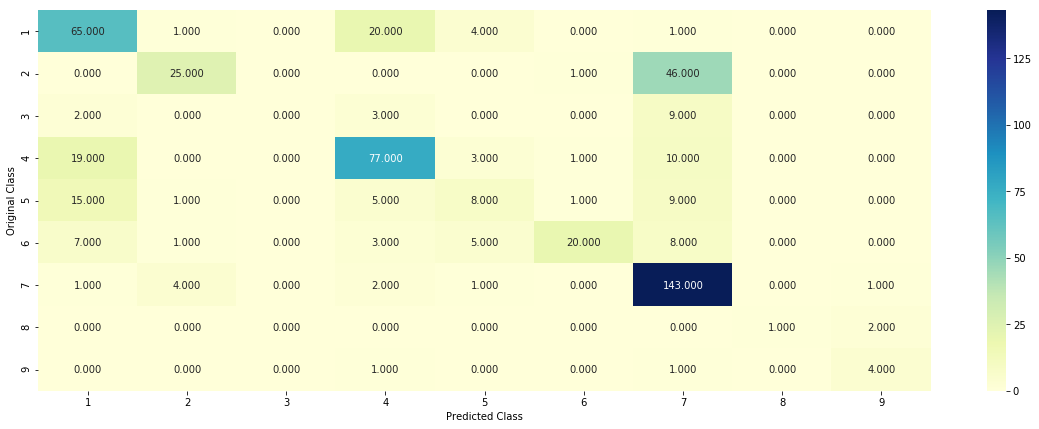

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


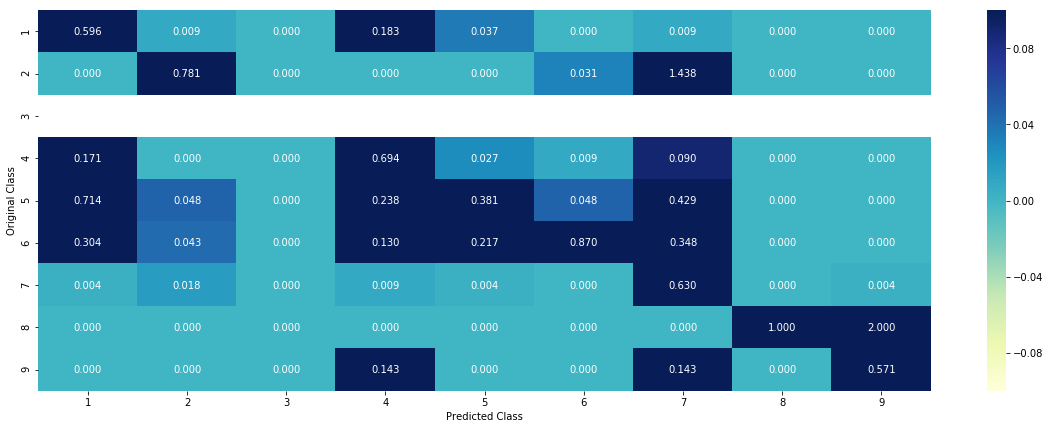

------------------------------ Recall matrix (Row sum=1) ------------------------------


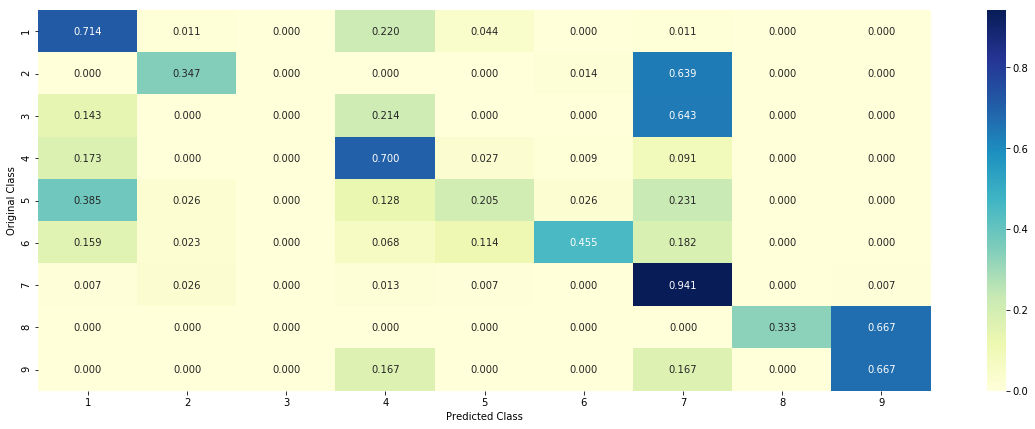

In [97]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotcoding, train_y, cv_x_onehotcoding, cv_y, clf)

** Sample point 1: **

In [98]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 1
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 2
predicted class probabilities: [[0.008 0.568 0.002 0.01  0.004 0.012 0.39  0.003 0.003]]
Actual Class: 2
111 Text feature [none] present in test data point [True]
170 Text feature [rate] present in test data point [True]
173 Text feature [step] present in test data point [True]
191 Text feature [patient] present in test data point [True]
192 Text feature [pcr] present in test data point [True]
Out of the top  200  features  5 are present in query point


** Sample point 2: **

In [103]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha_values[best_alpha], class_weight='balanced', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

test_point_index = 15
no_features = 200
predict_y = sig_clf.predict(test_x_onehotcoding[test_point_index])
print("Predicted class:", predict_y[0])
print("predicted class probabilities:", np.round(sig_clf.predict_proba(test_x_onehotcoding[test_point_index]), 3))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predict_y-1][:, :no_features]
get_imp_feature_names(indices[0], X_test.TEXT.iloc[test_point_index], X_test.Gene.iloc[test_point_index], X_test.Variation.iloc[test_point_index], no_features)

Predicted class: 1
predicted class probabilities: [[0.577 0.002 0.001 0.203 0.191 0.023 0.    0.001 0.   ]]
Actual Class: 4
88 Text feature [surfac] present in test data point [True]
109 Text feature [correct] present in test data point [True]
164 Text feature [fold] present in test data point [True]
192 Text feature [region] present in test data point [True]
Out of the top  200  features  4 are present in query point


# Summary:

** Log loss on train, cv and test datasets at various models, for text feature form an vectors using TFIDF with **

|Model                               |Hyperparameter     |Train       |CV    | Test   |% of misclassification points         
|------------------------------------|-------------------|------------|------|--------|-----------------------------|
|Naive Bayes                         |0.01               |0.514       |1.203 |1.194   |37.66%                       |
|KNN                                 |3                  |0.820       |1.331 |1.114   |37.85%                       |
|Logistic regression(Class balance)  |0.001              |0.697       |1.074 |1.044   |37.28                        |
|Logistic regression(Class Imbalance)|0.0001             |0.4181      |1.138 |1.063   |35.02%                       |
|Logistic regression(uni and bigrams)|10                 |0.967       |1.188 |1.207   |40.30%                       |
|Linear SVM                          |0.001              |0.567       |1.104 |1.073   |35.02%                       |
|Random Forest                       |2000               |0.862       |1.203 |1.195   |43.69%                       |
|Stacking models                     |0.1                |0.330       |1.179 |1.119   |34.80%                       |
|Maximum Voting                      |                   |0.466       |1.076 |1.045   |34.33%                       |

- By observing above models logistic regression with class balance has the less cv log_loss and test log_loss, so by taking that model further reducing the test log loss to less than 1.

---------------------------------------------------Logistic Regression   (Class balance)--------------------------------------
- So finally we got test log loss less than 1, applying for text feature with tfidf of parameters max_features = 5000 and minimum_count word is 5,

|Model                               |Hyperparameter     |Train       |CV    | Test   |% of misclassification points|         
|------------------------------------|-------------------|------------|------|--------|-----------------------------|
|Logistic regression(Class balance)  |0.0001             |0.418       |1.036 |0.9889  |35.40%                       |


** observation :**

- Given dataset is an imbalanced data from among all class majority class is 7 and it is an mulclassification problem.
- For this problem logistic regression model is working well as compared to all other algorithms.
- TEXT feature is the most important feature for this given dataset.